In [1]:
import numpy as np
from qiskit.circuit.library                   import RYGate,RZGate,RXGate,IGate,UGate,NLocal,TwoLocal,RealAmplitudes,XGate,HGate, RXXGate, RYYGate, RZZGate
from qiskit.circuit                           import Parameter
from qiskit.aqua.components.optimizers        import L_BFGS_B,COBYLA,CG,ADAM,SPSA,AQGD
from qiskit.aqua.components.initial_states    import *
from qiskit.aqua.algorithms                   import VQE
from qiskit.aqua                              import QuantumInstance,aqua_globals

from qiskit                                   import IBMQ
from qiskit.providers.aer.backends.aerbackend import AerBackend
from qiskit.providers.ibmq.ibmqbackend        import IBMQBackend
from qiskit.providers.aer                     import noise
from qiskit.providers.aer.noise               import NoiseModel
from qiskit.ignis.mitigation.measurement      import (complete_meas_cal,CompleteMeasFitter)
import logging
from qiskit.aqua                              import set_qiskit_aqua_logging
from qiskit.circuit                           import Parameter, ParameterVector
#set_qiskit_aqua_logging(logging.DEBUG) 

from   qiskit                                 import *
from   qiskit.quantum_info                    import Pauli,Operator
from   qiskit.aqua.operators                  import SummedOp,PauliOp,CircuitStateFn,WeightedPauliOperator, StateFn, PauliExpectation, CircuitSampler,AerPauliExpectation
from   qiskit.aqua.operators.primitive_ops    import MatrixOp
from   qiskit.aqua.operators.legacy           import MatrixOperator,op_converter
from   qiskit.aqua.algorithms                 import NumPyEigensolver,NumPyMinimumEigensolver
from   qiskit.compiler                        import transpile, assemble
from qiskit.aqua.operators                    import X, Y, Z, I
from qiskit.aqua.operators.gradients          import Gradient
from qiskit.converters                        import circuit_to_gate
from qiskit.tools.monitor                     import job_monitor
from qiskit.aqua.components.variational_forms import VariationalForm


import math
from math                                     import isclose
import matplotlib 
import matplotlib.pyplot as plt
from IPython.display                          import display, Markdown
import itertools

from scipy                                    import linalg as LA
from scipy.optimize                           import curve_fit
import functools
import time
from  typing                                  import List, Optional, Union

# Tomography functions
from qiskit.ignis.verification.tomography     import state_tomography_circuits, StateTomographyFitter
from qiskit.ignis.verification.tomography     import process_tomography_circuits, ProcessTomographyFitter
from qiskit.ignis.verification.tomography     import gateset_tomography_circuits, GatesetTomographyFitter
import qiskit.ignis.mitigation.measurement    as mc

In [2]:
def generate_pauli(idx_x,idx_z,n):
    '''
    Args:
       n   (integer)
       idx (List)
    Returns:
       tensor product of Pauli operators acting on qubits in idx
       Y = iZX
       P0 P1 P2 P3 P4
       Pi = (X)^a (Z)^b
    '''
    xmask = [0]*n
    zmask = [0]*n
    for i in idx_x: xmask[i] = 1
    for i in idx_z: zmask[i] = 1
    a_x = np.asarray(xmask,dtype=np.bool)
    a_z = np.asarray(zmask,dtype=np.bool)
    return Pauli(a_z,a_x)

#The following function is used to define the operators that appear in the Heisenberg hamiltonian above
#In PauliOp the default coefficient is 1.0
def generate_Heisenberg(nqubit,nn_list):
    pauli_list = []
    for (i,j) in nn_list:
        xixj = PauliOp(generate_pauli([i,j],[],nqubit));    pauli_list.append(xixj)
        yiyj = PauliOp(generate_pauli([i,j],[i,j],nqubit)); pauli_list.append(yiyj)
        zizj = PauliOp(generate_pauli([],[i,j],nqubit));    pauli_list.append(zizj)
    H = SummedOp(pauli_list)
    return H

#Here we define the spin operators acting on site i
#We note that this function returns the name of the operator (site+component) and its value
def generate_spin_operators(nqubit):
    spins = []
    for i in range(nqubit):
        xi = generate_pauli([i],[],nqubit);  spins.append( (str(i)+'x',PauliOp(xi,1.0)) )
        yi = generate_pauli([i],[i],nqubit); spins.append( (str(i)+'y',PauliOp(yi,1.0)) )
        zi = generate_pauli([],[i],nqubit);  spins.append( (str(i)+'z',PauliOp(zi,1.0)) )
    return spins

#We note that the argument aux_operators will be the output of function generate_spin_operators
def diagonalize_H(H,aux_operators):
    '''
    k = number of eigenvalues/eigenvectors to find
    H |ci) = Ei |ci)
    Ai = (ci|A|ci)
    aux_ops: list of length k; each element is an array of shape (nprops,2) for real and imaginary part
    '''
    ee = NumPyEigensolver(operator=H,k=2**H.num_qubits,aux_operators=[s for name_s,s in aux_operators])
    ee = ee.run()
    energies = np.real(ee['eigenvalues'])
    psi = ee['eigenstates']
    aux_ops = ee['aux_operator_eigenvalues']
    
    '''
    for i,(ei,ai) in enumerate(zip(energies,aux_ops)):
        print("Eigenstate number: ",i,"; Energy: ",round(ei,6))
        for js,(name_s,s) in enumerate(aux_operators):
            print("     Spin ",name_s,round(ai[js][0],6))  #ai[js] has two arguments: the real and imaginary parts
        print("Eigenvector:")
        psi_i = psi[i].primitive.to_dict()
        for k in psi_i.keys():
            print("     ",k,psi_i[k])
    '''
    return energies,psi,aux_ops

def generate_spinspin_operators(nqubit):
    spin_spin=[]
    for i in range(nqubit):
        for j in range(nqubit):
            xi = PauliOp(generate_pauli([i],[],nqubit));
            xj = PauliOp(generate_pauli([j],[],nqubit));
            
            yi = PauliOp(generate_pauli([i],[i],nqubit));
            yj = PauliOp(generate_pauli([j],[j],nqubit));
            
            zi = PauliOp(generate_pauli([],[i],nqubit));
            zj = PauliOp(generate_pauli([],[j],nqubit));
            
            spin_spin.append( (str(i)+'x-'+str(j)+'x',xi.compose(xj)))
            spin_spin.append( (str(i)+'y-'+str(j)+'y',yi.compose(yj)) )
            spin_spin.append( (str(i)+'z-'+str(j)+'z',zi.compose(zj)) )
            
    return spin_spin

def to_ket(psi):
    """ Write a statevector in braket notation.
    Parameters
    ----------
    ψ: ndarray
        the statevector
    Returns
    -------
    ket: str
        the statevector in braket notation
    """
    # GET WIDTH OF EACH STATE LABEL
    n = int(np.ceil(np.log2(len(psi))))
    # CONSTRUCT STRING ONE STATE AT A TIME
    ket = ""
    for i, c in enumerate(psi):
        # PREPARE STATE LABEL
        label = np.binary_repr(i,n)     # CONVERT INDEX TO CORRESPONDING LABEL
        label = label[::-1]             # (OPTIONAL) USE ALTERNATE INDEXING
        # UPDATE ket STRING
        if np.round(c,3)!=0.:
            if i > 0: ket += " + "
            ket += f"({c:.3f}) |{label}⟩"   # (OPTIONAL) FIX COEFFICIENT'S PRECISION
    return ket

def to_state(psi):
    # GET WIDTH OF EACH STATE LABEL
    n = int(np.ceil(np.log2(len(psi))))
    #state = np.zeros(len(psi),dtype=np.complex_)
    state=np.zeros(len(psi),dtype=float)
    for i, c in enumerate(psi):
        # PREPARE STATE LABEL
        label = np.binary_repr(i,n)     # CONVERT INDEX TO CORRESPONDING LABEL
        label = label[::-1]             # (OPTIONAL) USE ALTERNATE INDEXING

        v=[np.zeros(2,dtype=float) for i in range(n)]
        for k in range(n):
            v[k][int(label[k])]=1.
                    
        #print(label,v)
        val=np.kron(v[0],v[1])
        for j in range(2,n):
            val=np.kron(val,v[j])
        val=np.dot(c,val)
        state+=val
    return state


#### Functions to define exact total spin eigenstates

In [3]:
def sign(x):
    if(x>0): 
        return  1
    else:    
        return -1

def convert(x):
    return int(round(np.abs(2*x)))

def get_clebsch(j1,m1,j2,m2,J,M):
    from sympy.physics.quantum.cg import CG
    # S is the shortcut for sympify and converts an arbitrary expression to a type that can be used inside SymPy
    sgnJ  = sign(J) 
    from sympy import S     
    sgnM  = sign(M)
    sgnj1 = sign(j1)
    sgnm1 = sign(m1)
    sgnj2 = sign(j2)
    sgnm2 = sign(m2)
    numJ  = convert(J)
    numM  = convert(M)
    numj1 = convert(j1)
    numm1 = convert(m1)
    numj2 = convert(j2)
    numm2 = convert(m2)
    cg = CG(sgnj1*S(numj1)/2,sgnm1*S(numm1)/2,sgnj2*S(numj2)/2,sgnm2*S(numm2)/2,sgnJ*S(numJ)/2,sgnM*S(numM)/2)
    return float(cg.doit().evalf())

# ------------------------------------------------------

# Remark - It's important to notice that the vector associated with psi_JM is a matrix, therefore the indexes we print in the following function are the
#          matrix indexes on which we have a non-zero value. By this way the indexes can be read also as up or down spin vectors.
#          E.g. (0,1,1) --> (up,down,down)

def print_states(psi_dict):
    for k in psi_dict.keys():
        print("State ",k)
        n = len(psi_dict[k].shape)
        for idx in itertools.product([0,1],repeat=n):
            c = psi_dict[k][idx]
            # If we don't insert the following "if", we would see all the null contributes to the state |J,M>
            if(not isclose(c,0.0,abs_tol=1e-4)):
                print(idx," ",c)
        print(" ")
            
# Given the z-component of spin, m, the following function returns the vectors (1 0)^T (j=1/2, m=1/2) or (0 1)^T (j=1/2, m=-1/2)
def one_spin_states(j,m):
    # isclose returns True if two values are closer than the abs_tol
    if(isclose(m,0.5,abs_tol=1e-4)):        
        i=0
    else:                            
        i=1
    psi    = np.zeros(2)
    psi[i] = 1.0
    return psi[:]

def compose_two_spins(label=''):
    psi = {}
    j1,j2 = 1.0/2.0,1.0/2.0
    for J in [0,1]:
        for M in range(-J,J+1):
            psi_JM = np.zeros((2,2))
            for x1 in [0,1]:
                for x2 in [0,1]:
                    m1,m2 = (x1-j1),(x2-j2)
                    cg = get_clebsch(j1=j1,m1=m1,j2=j2,m2=m2,J=J,M=M)
                    psi_JM += cg*np.einsum('a,b->ab',one_spin_states(j1,m1),one_spin_states(j2,m2))
            #print(psi_JM)
            psi[label+'_'+str(J)+'_'+str(M)] = psi_JM
    return psi

def compose_with_center(psi_left,label=''):
    psi = {}
    j2 = 1.0/2.0
    for j1 in [0,1]:
        for J in np.arange(np.abs(j2-j1),j1+j2+1e-4,1):
            for M in np.arange(-J,J+1e-4,1.0):
                psi_JM_j1 = np.zeros((2,2,2))
                for x1 in range(2*j1+1):
                    for x2 in [0,1]:
                        m1,m2 = (x1-j1),(x2-j2)
                        cg = get_clebsch(j1=j1,m1=m1,j2=j2,m2=m2,J=J,M=M)
                        psi_JM_j1 += cg*np.einsum('ab,c->abc',psi_left[label+'_'+str(j1)+'_'+str(m1)],one_spin_states(j2,m2))
                psi[label+'_j1_'+str(j1)+'_lc_'+str(J)+'_'+str(M)] = psi_JM_j1
    return psi

def compose_with_right(psi_lc,psi_r):
    psi={}
    lc_list=[]

    for k in psi_lc.keys():
        klc = k.split('_')
        lab_lc=klc[0]
        jL = float(klc[2])
        j1 = float(klc[4])
        if((jL,j1) not in lc_list):
            lc_list.append((jL,j1))

    for k in psi_r.keys():
        kr=k.split("_")
        lab_r=kr[0]
        break

    for el in lc_list:
        jL=int(el[0])
        j1=el[1]
        #print(jL, " ", j1)
        for j2 in [0,1]:
            for J in np.arange(np.abs(j2-j1),j1+j2+1e-4,1):
                #print(" ",J)
                for M in np.arange(-J,J+1e-4,1.0):
                    # Label with spin left jL, spin right jR and spin left + center jLC 
                    lab = 'jL_'+str(jL)+'_jR_'+str(j2)+'_jLC_'+str(j1)+'_LCR_'+str(J)+'_'+str(M)
                    psi[lab] = np.zeros((2,2,2,2,2))
                    for m1 in np.arange(-j1,j1+1e-4,1):
                        for m2 in np.arange(-j2,j2+1e-4,1):
                            lab1=lab_lc+'_j1_'+str(jL)+'_lc_'+str(j1)+'_'+str(m1)
                            lab2=lab_r+'_'+str(j2)+'_'+str(int(m2))
                            cg = get_clebsch(j1=j1,m1=m1,j2=j2,m2=m2,J=J,M=M)
                            psi[lab] += cg*np.einsum('abc,de->abcde',psi_lc[lab1],psi_r[lab2])
    return psi

#### Measure operator on hardware

**Remarks**

- The `evaluate_with_result` method of `WeightedPauliOperator` returns the mean value and the standard deviation instead of the variance.

- If `measure` is initialized with a list of circuits, the function returns a list of mean values and standard deviations.

In [4]:
def measure(op,circ,instance):
    # Conversion from SummedOp to WeightedPauliOperator
    operator = op_converter.to_weighted_pauli_operator(MatrixOperator(op.to_matrix()))
    
    circuit  = operator.construct_evaluation_circuit(wave_function               = circ,
                                                     statevector_mode            = instance.is_statevector,
                                                     use_simulator_snapshot_mode = False,
                                                     circuit_name_prefix         = 'EvalCircuit')
    print("Job pending",end=" ")
    result = instance.execute(circuit)
    print("Job completed")
    
    mean,std = operator.evaluate_with_result(result                      = result,
                                             statevector_mode            = instance.is_statevector,
                                             use_simulator_snapshot_mode = False,
                                             circuit_name_prefix         = 'EvalCircuit')
    mean,std = np.real(mean),np.abs(std)
    return mean,std

#### Definition of spin operators: $\hat{S}_x$, $\hat{S}_y$, $\hat{S}_z$, $\hat{S}^2$

In [5]:
op_s022 = (1.5*I^I^I) + (0.5*X^I^X) + (0.5*Y^I^Y) + (0.5*Z^I^Z) 
op_sl2  = (1.5*I^I^I) + (0.5*I^X^X) + (0.5*I^Y^Y) + (0.5*I^Z^Z) 
op_sx   = (0.5*I^I^X) + (0.5*I^X^I) + (0.5*X^I^I)
op_sy   = (0.5*I^I^Y) + (0.5*I^Y^I) + (0.5*Y^I^I)
op_sz   = (0.5*I^I^Z) + (0.5*I^Z^I) + (0.5*Z^I^I)
op_s2   = (op_sx@op_sx + op_sy@op_sy + op_sz@op_sz).to_pauli_op()

#### IBM connection and main variables

In [6]:
nqubits = 3
lab_list = [(0,0.5,-0.5),(0,0.5,0.5),(1,0.5,-0.5),(1,0.5,0.5),(1,1.5,-1.5),(1,1.5,-0.5),(1,1.5,0.5),(1,1.5,1.5)]
shot_list = [100,200,500,1000,2000,4000,8000]

IBMQ.load_account()                                                  # connettersi a IBMQ
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
device   = provider.get_backend('ibmq_athens')                        # 5 qubit, lineare, buono
#device   = provider.get_backend('ibmq_5_yorktown')                   # 5 qubit, papillon, medio
#device   = provider.get_backend('ibmq_16_melbourne')                 # 16 qubit, "ladder", cattivo
backend  = Aer.get_backend('qasm_simulator') 

/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


#### Definition of the target state for $3$-spin circuits

In [7]:
target_state = []
for l in lab_list:
    circ3 = QuantumCircuit(nqubits)

    # theta gives the angle to use in the Ry Gate
    theta=np.arccos(get_clebsch(l[0],l[2]-0.5,0.5,0.5,l[1],l[2]))

    circ3.ry(2*theta,1)                                         # Remember that we need to insert 2*theta

    if l[0]==0:
        circ3.cx(1,0)
        circ3.ch(1,0)
        circ3.cx(1,2)

    elif l[0]==1:
        if l[2]+0.5==0:
            circ3.ch(1,0)
            circ3.cx(1,2)
        elif l[2]+0.5==-1:
            circ3.cx(1,0)

    circ3.x(1)

    if l[0]==0:
        circ3.cx(1,0)
        circ3.ch(1,0)
        circ3.cx(1,2)

    elif l[0]==1:
        if l[2]-0.5==0:
            circ3.ch(1,0)
            circ3.cx(1,2)
        elif l[2]-0.5==-1:
            circ3.cx(1,0)

    circ3.x(1)
    circ3.cx(0,2)

    # Target state associated to the circuit on th first three qubits
    target_state.append(qiskit.quantum_info.Statevector.from_instruction(circ3))

In [8]:
psi_L   = compose_two_spins('L')
psi_R   = compose_two_spins('R')
psi_LC  = compose_with_center(psi_L,'L')

print("States LC - Number: ",len(psi_LC.keys()))
print_states(psi_LC)

eig_3spins=[]
for v in psi_LC.values():
    # We use concatenate 2 times because the vectors have been built using np.zeros((2,2,2))
    eig_3spins.append(np.concatenate(np.concatenate(v)))

States LC - Number:  8
State  L_j1_0_lc_0.5_-0.5
(0, 1, 1)   0.7071067811865476
(1, 0, 1)   -0.7071067811865476
 
State  L_j1_0_lc_0.5_0.5
(0, 1, 0)   0.7071067811865476
(1, 0, 0)   -0.7071067811865476
 
State  L_j1_1_lc_0.5_-0.5
(0, 1, 1)   0.408248290463863
(1, 0, 1)   0.408248290463863
(1, 1, 0)   -0.816496580927726
 
State  L_j1_1_lc_0.5_0.5
(0, 0, 1)   0.816496580927726
(0, 1, 0)   -0.408248290463863
(1, 0, 0)   -0.408248290463863
 
State  L_j1_1_lc_1.5_-1.5
(1, 1, 1)   1.0
 
State  L_j1_1_lc_1.5_-0.5
(0, 1, 1)   0.5773502691896258
(1, 0, 1)   0.5773502691896258
(1, 1, 0)   0.5773502691896257
 
State  L_j1_1_lc_1.5_0.5
(0, 0, 1)   0.5773502691896257
(0, 1, 0)   0.5773502691896258
(1, 0, 0)   0.5773502691896258
 
State  L_j1_1_lc_1.5_1.5
(0, 0, 0)   1.0
 


# VQE circuits on hardware

## $R_y$ circuits

### $\bullet$ `cost_fn=spin_cost`, `grad_fn=grad_spin_cost` working on `Gradient("param_shift")`

We use as cost function and gradient function `spin_cost` and `grad_spin_cost`, respectively. `grad_spin_cost` uses `Gradient("param_shift")` inside.

Now we use the hardware test with:
- **fixed number of shots** ($8192$) 
- hardware device **IBM Athens**  

### Analysis of the gradient

#### Definition of the cost function and the corresponding gradient

In [8]:
def spin_cost(x):
    # QASM - Expectation values
    circ = var_form.assign_parameters(x)

    braket1 = StateFn(op_sl2,is_measurement=True)@CircuitStateFn(primitive=circ)
    grouped = PauliExpectation().convert(braket1)                    # Convert to expectation value
    sampled_op = CircuitSampler(instance).convert(grouped)           # Get state sampler (you can also pass the backend directly)
    f1=sampled_op.eval().real                                        # Get expectation value

    braket2 = StateFn(op_s2,is_measurement=True)@CircuitStateFn(primitive=circ)
    grouped = PauliExpectation().convert(braket2)                    # Convert to expectation value
    sampled_op = CircuitSampler(instance).convert(grouped)           # Get state sampler (you can also pass the backend directly)
    f2=sampled_op.eval().real                                        # Get expectation value

    braket3 = StateFn(op_sz,is_measurement=True)@CircuitStateFn(primitive=circ)
    grouped = PauliExpectation().convert(braket3)                    # Convert to expectation value
    sampled_op = CircuitSampler(instance).convert(grouped)           # Get state sampler (you can also pass the backend directly)
    f3=sampled_op.eval().real                                        # Get expectation value

    return (f1-l[0]*(l[0]+1))**2 + (f2-l[1]*(l[1]+1))**2 + (f3-l[2])**2

def grad_spin_cost(x):
    
    # Here we create the dictionary which associates at each Parameter the corresponding value
    pv=var_form.ordered_parameters
    par={pv[i] : x[i] for i in range(len(pv))}
    
    # QASM
    # Expectation values
    circ=var_form.assign_parameters(x)

    braket1=StateFn(op_sl2,is_measurement=True)@CircuitStateFn(primitive=circ)
    grouped = PauliExpectation().convert(braket1)                    # Convert to expectation value
    sampled_op = CircuitSampler(instance).convert(grouped)           # Get state sampler (you can also pass the backend directly)
    f1=sampled_op.eval().real                                        # Get expectation value

    braket2=StateFn(op_s2,is_measurement=True)@CircuitStateFn(primitive=circ)
    grouped = PauliExpectation().convert(braket2)                    # Convert to expectation value
    sampled_op = CircuitSampler(instance).convert(grouped)           # Get state sampler (you can also pass the backend directly)
    f2=sampled_op.eval().real                                        # Get expectation value

    braket3=StateFn(op_sz,is_measurement=True)@CircuitStateFn(primitive=circ)
    grouped = PauliExpectation().convert(braket3)                    # Convert to expectation value
    sampled_op = CircuitSampler(instance).convert(grouped)           # Get state sampler (you can also pass the backend directly)
    f3=sampled_op.eval().real                                        # Get expectation value
    
    # Gradients
    state_grad1=grad.convert(operator=~StateFn(op_sl2) @ CircuitStateFn(primitive=var_form),params=pv)
    state_grad2=grad.convert(operator=~StateFn(op_s2) @ CircuitStateFn(primitive=var_form),params=pv)
    state_grad3=grad.convert(operator=~StateFn(op_sz) @ CircuitStateFn(primitive=var_form),params=pv)

    g1=[np.real(el) for el in state_grad1.assign_parameters(par).eval()]
    g2=[np.real(el) for el in state_grad2.assign_parameters(par).eval()]
    g3=[np.real(el) for el in state_grad3.assign_parameters(par).eval()]

    grad_val=[]
    for i in range(len(g1)):
        grad_val.append(2*(f1-l[0]*(l[0]+1))*g1[i] + 2*(f2-l[1]*(l[1]+1))*g2[i] + 2*(f3-l[2])*g3[i])

    return grad_val

#### Gradient evaluation

#### $\bullet$ `qasm_simulator`

In [12]:
# Initial state of the VQE
psi_1= Zero(3)
#Here we define the circuit upon initial state assumption
var_form  = RealAmplitudes(3,initial_state=psi_1,entanglement=[(0,1),(1,2)],insert_barriers=True,reps=3)
print("Number of parameters: "+str(var_form.num_parameters))

grad = Gradient(grad_method='param_shift')
# Vector of random parameters to insert inside var_form
x = [np.random.random() for i in range(var_form.num_parameters)]
#print(x)

# Qasm simulator with noise model
instance = QuantumInstance(backend                          = backend,
                           shots                            = 8192,
                           optimization_level               = 3,
                           initial_layout                   = [0,1,2])

l = lab_list[0]

grad_val = []
for i in range(5):
    grad_val.append(grad_spin_cost(x))

In [23]:
print("qasm_simulator - Standard deviation on each component of the gradient")
for i in range(var_form.num_parameters):
    list_comp = [el[i] for el in grad_val]
    print("Component {} : {}".format(i,np.std(list_comp)))

qasm_simulator - Standard deviation on each component of the gradient
Component 0 : 0.0020338150848493966
Component 1 : 0.005578536160566872
Component 2 : 0.001257479086826987
Component 3 : 0.006963055225087312
Component 4 : 0.004724433914623968
Component 5 : 0.0018173443756443408
Component 6 : 0.00829924615117063
Component 7 : 0.0019305197724137709
Component 8 : 0.004898687406547823
Component 9 : 0.006318557495924465
Component 10 : 0.0077981179701631705
Component 11 : 0.006126116019657268


#### $\bullet$ `ibmq_athens`

In [24]:
# Initial state of the VQE
psi_1= Zero(3)
#Here we define the circuit upon initial state assumption
var_form  = RealAmplitudes(3,initial_state=psi_1,entanglement=[(0,1),(1,2)],insert_barriers=True,reps=3)
print("Number of parameters: "+str(var_form.num_parameters))

grad = Gradient(grad_method='param_shift')
# Vector of random parameters
x = [np.random.random() for i in range(var_form.num_parameters)]
#print(x)

# Hardware
instance = QuantumInstance(backend                          = device,
                           shots                            = 8192,
                           coupling_map                     = device.configuration().coupling_map,
                           optimization_level               = 3,
                           initial_layout                   = [0,1,2])

l = lab_list[0]

grad_val = []
for i in range(5):
    grad_val.append(grad_spin_cost(x))

Number of parameters: 12


In [25]:
print("ibmq_athens - Standard deviation on each component of the gradient")
for i in range(var_form.num_parameters):
    list_comp = [el[i] for el in grad_val]
    print("Component {} : {}".format(i,np.std(list_comp)))

ibmq_athens - Standard deviation on each component of the gradient
Component 0 : 0.00566961022491533
Component 1 : 0.01703960325306301
Component 2 : 0.00954637020869792
Component 3 : 0.018561987699697365
Component 4 : 0.0219300417155565
Component 5 : 0.0041653930419304555
Component 6 : 0.012865932826104329
Component 7 : 0.010235267919520227
Component 8 : 0.01342456782995106
Component 9 : 0.01927200928341838
Component 10 : 0.02354469769041256
Component 11 : 0.006702322522986322


#### Analysis of expectation values with different `gtol` ( $|s_L=0,s=1/2,s_z=- 1/2 \rangle$ )

In particular we are going to consider the expectation values of $\{\hat{S}_L^2, \hat{S}^2,\hat{S}_z\}$ on the optimal circuits given for the state $|s_L=0,s=1/2,s_z=- 1/2 \rangle$. We compare the results with an increasing value of gradient tolerance `gtol`. The results come from the `ibmq_athens` device.

The expectation values have been corrected using the readout error mitigation (EM) and the Richardson extrapolation (RE).

**CG Parameters**:
- `maxiter = 70`
- `gtol` $\in \{10^{-12},10^{-10},10^{-8},10^{-6},10^{-4},10^{-2}\}$

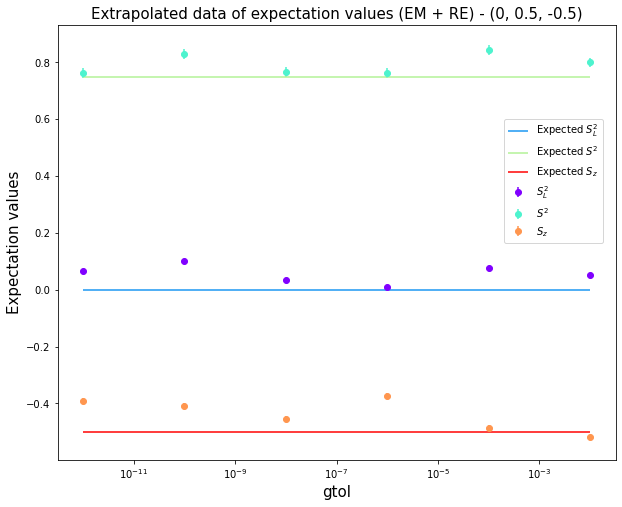

In [67]:
file = open("Results/VQE_spin_gtol_analysis.out")      
line = file.readlines()
line_val = []
for el in line:
    el2 = el.split()
    if el2[0]!="Job":
        line_val.append(el2)

l = lab_list[0]      
op_labels = [r"$S_L^2$",r"$S^2$",r"$S_z$"]

data_re = [[] for i in range(6)]
err_re  = [[] for i in range(6)]
gtol = [10**(-12+2*i) for i in range(6)]   # gtol values
cl=0        # Count lines
for i in range(6):
    data_1,err_1=[],[]
    data_3,err_3=[],[]
    data_5,err_5=[],[]
    for j in range(9):
        val = line_val[cl]
        if j<3:
            data_1.append(float(val[0]))
            err_1.append(float(val[1]))    # Standard deviation!
        elif j>=3 and j<6:
            data_3.append(float(val[0]))
            err_3.append(float(val[1]))    # Standard deviation!
        elif j>=6 and j<9:
            data_5.append(float(val[0]))
            err_5.append(float(val[1]))    # Standard deviation!
        cl+=1
    
    for k in range(len(data_1)):
        #print([data_1[k],data_3[k],data_5[k]])
        p_ave, p_cov = curve_fit(straight_line,[1,3,5],[data_1[k],data_3[k],data_5[k]],sigma=[err_1[k],err_3[k],err_5[k]],absolute_sigma=True)
        data_re[i].append(p_ave[1])
        err_re[i].append(np.sqrt(p_cov[1,1]))

plt.figure(figsize=(10,8))
jet = plt.get_cmap('rainbow')
colors = iter(jet(np.linspace(0,1,6)))
# Data
for j in range(3):
    data,err = [],[]
    for i in range(6):
        data.append(data_re[i][j])
        err.append(err_re[i][j])
    plt.errorbar(gtol,data,yerr=err,marker='o',ls="none",label=op_labels[j],color=next(colors))
    if j==2:
        plt.hlines(l[j],gtol[0],gtol[-1],label="Expected "+op_labels[j],color=next(colors))
    else:
        plt.hlines(l[j]*(l[j]+1),gtol[0],gtol[-1],label="Expected "+op_labels[j],color=next(colors))
    
plt.title("Extrapolated data of expectation values (EM + RE) - "+str(l),size=15)
plt.xlabel("gtol",size=15)
plt.xticks(gtol)
plt.xticks
plt.xscale("log")
plt.ylabel("Expectation values",size=15)
plt.legend(loc=(0.8,0.5))
plt.show()

### $|s_L=0,s=1/2,s_z= \pm 1/2 \rangle$
#### Expectation values and Richardson extrapolation analysis

The RE results have been obtained using the CNOT multiplication method and considering the data corresponding to $N_{CNOT}=1,3,5$.

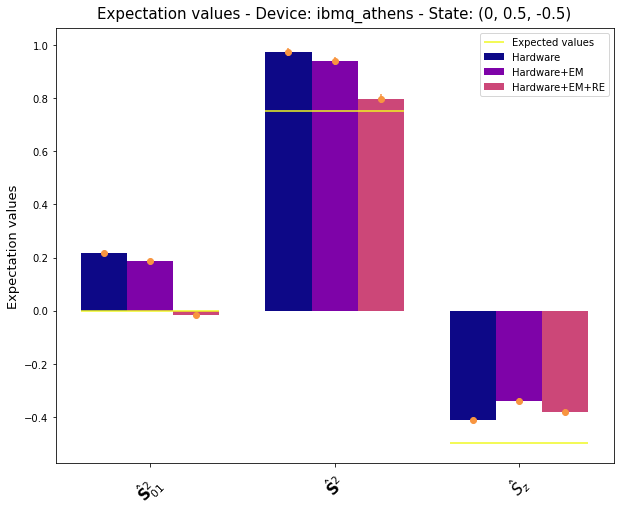

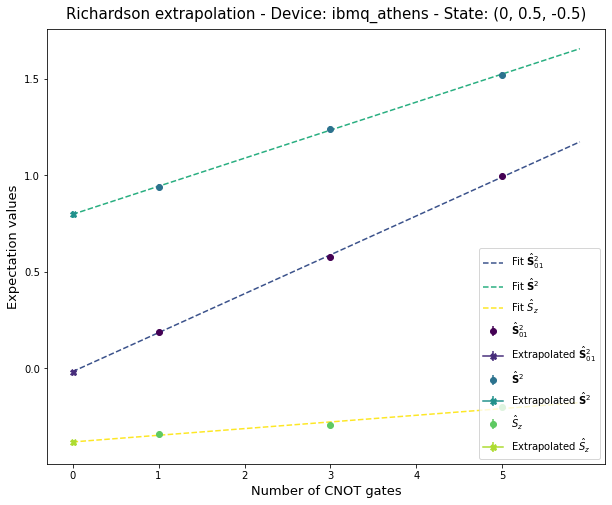

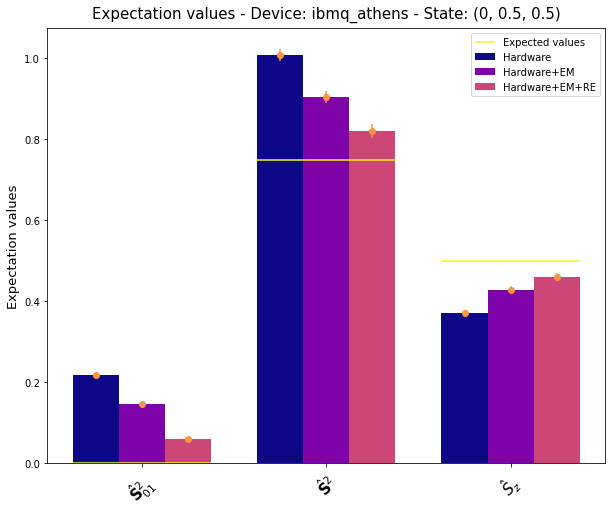

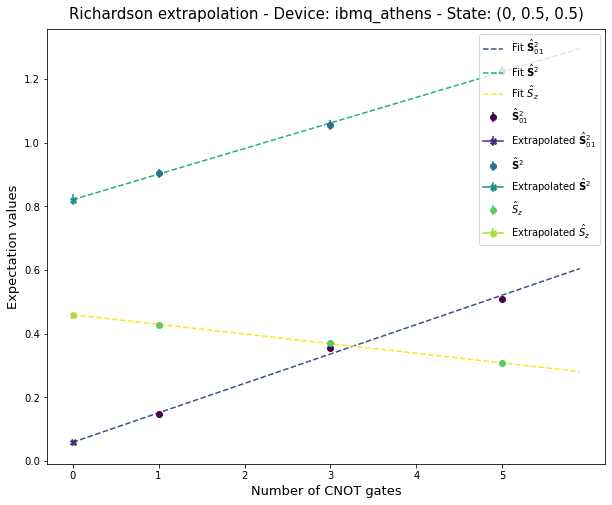

In [12]:
# Definition of straight line
def straight_line(x,m,q):
    return m*x+q

file=open("Results/VQE_spin_hardware_ry1.out")      
line=file.readlines()
line_val = []
for el in line:
    el2 = el.split()
    if el2[0]!="Job":
        line_val.append(el2)

s= 8192     # Number of shots
cl=0        # Count lines
for i in range(2):
    data_raw,err_raw=[],[]
    data_1,err_1=[],[]
    data_3,err_3=[],[]
    data_5,err_5=[],[]
    data_re,err_re=[],[]
    for j in range(15):
        val = line_val[cl]
        if j<3:
            data_raw.append(float(val[0]))
            err_raw.append(float(val[1]))    # Standard deviation!
        elif j>=3 and j<6:
            data_1.append(float(val[0]))
            err_1.append(float(val[1]))    # Standard deviation!
        elif j>=6 and j<9:
            data_3.append(float(val[0]))
            err_3.append(float(val[1]))    # Standard deviation!
        elif j>=9 and j<12:
            data_5.append(float(val[0]))
            err_5.append(float(val[1]))    # Standard deviation!
        #elif j>=12 and j<15:
        #    data_re.append(float(val[0]))
        #    err_re.append(float(val[1]))    # Standard deviation!
        cl+=1
    
    for k in range(len(data_1)):
        #print([data_1[k],data_3[k],data_5[k]])
        p_ave, p_cov = curve_fit(straight_line,[1,3,5],[data_1[k],data_3[k],data_5[k]],sigma=[err_1[k],err_3[k],err_5[k]],absolute_sigma=True)
        data_re.append(p_ave[1])
        err_re.append(np.sqrt(p_cov[1,1]))
                                                                                                                                                                  
    # The histograms - Plot of expectation values
    op_labels=[r"$\hat{\mathbf{S}}_{01}^2$",r"$\hat{\mathbf{S}}^2$",r"$\hat{S}_z$"]
    
    jet = plt.get_cmap('plasma')
    colors = iter(jet(np.linspace(0,1,5)))
    
    l = lab_list[i]
    fig, ax = plt.subplots(figsize=(10,8))
    x_lab=np.arange(3)
    width=0.25

    rects1 = ax.bar(x_lab - width, data_raw, width, label='Hardware',color=next(colors))
    rects2 = ax.bar(x_lab, data_1, width, label='Hardware+EM',color=next(colors))
    rects3 = ax.bar(x_lab + width, data_re, width, label='Hardware+EM+RE',color=next(colors))
    
    c = next(colors)
    ax.errorbar(x_lab - width,data_raw,yerr=err_raw,fmt='o',color=c)
    ax.errorbar(x_lab,data_1,yerr=err_1,fmt='o',color=c)
    ax.errorbar(x_lab + width,data_re,yerr=err_re,fmt='o',color=c)
    
    c = next(colors)
    ax.hlines(y=l[0]*(l[0]+1), xmin=0-3*width/2, xmax=0+3*width/2,colors=c)
    ax.hlines(y=l[1]*(l[1]+1), xmin=1-3*width/2, xmax=1+3*width/2,colors=c)
    ax.hlines(y=l[2], xmin=2-3*width/2, xmax=2+3*width/2,colors=c,label="Expected values")

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Expectation values',fontsize=13)
    ax.set_title(r'Expectation values - Device: ibmq_athens - State: '+str(l),fontsize=15,pad=10)
    ax.set_xticks(x_lab)
    ax.set_xticklabels(op_labels,rotation=45,size=15)
    ax.legend()
    if i==0:
        plt.savefig("/Users/Alecoal/Desktop/Tesi/Text_Thesis/Pictures/RY_hardware_3_"+str(i)+".pdf")
    
    # Richardson extrapolation analysis
    jet = plt.get_cmap('viridis')
    colors = iter(jet(np.linspace(0,1,9)))
    
    plt.figure(figsize=(10,8))
    for j in range(3):
        # Data
        plt.errorbar([1,3,5],[data_1[j],data_3[j],data_5[j]],yerr=[err_1[j],err_3[j],err_5[j]],marker='o',ls="none",label=op_labels[j],color=next(colors))
        # Extrapolated data
        p_ave,p_cov = curve_fit(straight_line,[1,3,5],[data_1[j],data_3[j],data_5[j]],sigma=[err_1[j],err_3[j],err_5[j]],absolute_sigma=True)                                                                                    
        plt.errorbar([0],[p_ave[1]],yerr=[np.sqrt(p_cov[1,1])],marker='X',label='Extrapolated '+op_labels[j],color=next(colors))
        # Fit
        u = list(np.arange(0,6,0.1))
        v = [straight_line(ui,p_ave[0],p_ave[1]) for ui in u]
        plt.plot(u,v,'--',label='Fit '+op_labels[j], color=next(colors))                                                                                    
    
    plt.title("Richardson extrapolation - Device: ibmq_athens - State: "+str(l),size=15,pad=10)
    plt.xlabel("Number of CNOT gates",size=13)
    plt.xticks(np.arange(6))
    plt.ylabel("Expectation values",size=13)
    plt.legend()
    if i==0:
        plt.savefig("/Users/Alecoal/Desktop/Tesi/Text_Thesis/Pictures/RY_hardware_3_RE_"+str(i)+".pdf")

#### $|s_L=0,s=1/2,s_z= \pm 1/2 \rangle$: Cost function and fidelity (computed with state tomography) of the optimal circuit

In [44]:
cl=30

psi_1= Zero(3)
#Here we define the circuit upon initial state assumption
var_form  = RealAmplitudes(3,initial_state=psi_1,entanglement=[(0,1),(1,2)],insert_barriers=True,reps=3)
#print("Number of parameters: "+str(var_form.num_parameters))

rho_fit_mit = []

for i in range(2):
    print("State label: ",lab_list[i])
    for j in range(2):
        param=[]
        if j==0:
            print("       Hardware results")
        if j==1:
            print("       Hardware + readout error mitigation results")
        for k in range(13):
            val=line_val[cl]
            if k==0:
                print("              C(s_L,s,s_z) = ",val[0])
            else:
                param.append(float(val[0]))
            cl+=1
        
        best_circ = var_form.assign_parameters(param)          # With RealAmplitudes/TwoLocal
        #best_circ = var_form.construct_circuit(param)         # With VariationalForm
        best_psi = CircuitStateFn(best_circ).to_matrix()
        # The best state
        #print("          | optimal > = ",to_ket(best_psi))
        
        # STATE TOMOGRAPHY only for mitigated results
        if j==1:
            # Generate the state tomography circuit
            tomo_circ = state_tomography_circuits(best_circ,[0,1,2])
            # Execute
            job = qiskit.execute(tomo_circ, device, shots=8192)
            # Fit result
            tomo_fitter = StateTomographyFitter(job.result(), tomo_circ)
            # Perform the tomography fit which outputs a density matrix
            rho_fit_mit.append(tomo_fitter.fit(method='lstsq'))  
            fid_mit = qiskit.quantum_info.state_fidelity(rho_fit_mit[i], target_state[i])
            print('              State fidelity (tomography with readout error mitigation): F = {:.5f}'.format(fid_mit))

State label:  (0, 0.5, -0.5)
       Hardware results
              C(s_L,s,s_z) =  0.09445530196609468
       Hardware + readout error mitigation results
              C(s_L,s,s_z) =  0.08211207521026016
              State fidelity (tomography with readout error mitigation): F = 0.14895
State label:  (0, 0.5, 0.5)
       Hardware results
              C(s_L,s,s_z) =  0.11212345715815333
       Hardware + readout error mitigation results
              C(s_L,s,s_z) =  0.027077461277077393
              State fidelity (tomography with readout error mitigation): F = 0.19794


#### $|s_L=0,s=1/2,s_z= \pm 1/2 \rangle$: Fidelity of the optimal circuits (computed with the corresponding circuit matrix)

In [17]:
cl=30

psi_1= Zero(3)
#Here we define the circuit upon initial state assumption
var_form  = RealAmplitudes(3,initial_state=psi_1,entanglement=[(0,1),(1,2)],insert_barriers=True,reps=3)
#print("Number of parameters: "+str(var_form.num_parameters))

v0 = [0]*nqubits
v0[0] = 1

for i in range(2):
    print("State label: ",lab_list[i])
    for j in range(2):
        param=[]
        if j==0:
            print("       Hardware results")
        if j==1:
            print("       Hardware + readout error mitigation results")
        for k in range(13):
            val=line_val[cl]
            if k==0:
                c = val[0]
                #print("              C(s_L,s_s_z) = ",c)
            else:
                param.append(float(val[0]))
            cl+=1
        
        best_circ = var_form.assign_parameters(param)          # With RealAmplitudes/TwoLocal
        #best_circ = var_form.construct_circuit(param)         # With VariationalForm
        best_psi = CircuitStateFn(best_circ).to_matrix()
        best_ket = to_ket(best_psi)
        #print(best_ket)
        
        # Fidelity 
        fid = np.abs(np.dot(np.conj(eig_3spins[i]),best_psi))**2
        print("              Fidelity: F = ",fid)

State label:  (0, 0.5, -0.5)
       Hardware results
              Fidelity: F =  0.2849779731950463
       Hardware + readout error mitigation results
              Fidelity: F =  0.2747829321521066
State label:  (0, 0.5, 0.5)
       Hardware results
              Fidelity: F =  0.18798410248235586
       Hardware + readout error mitigation results
              Fidelity: F =  0.26983027090428513


#### Summary table on FIDELITIES

**EM** = (Readout) Error Mitigation

Statevector is used to refer to the matric which comes from the circuit conversion to the 2D-array.

|State label| Tomography (with EM)| Statevector  | Statevector (with EM) |
| :-: | :-: | :-: | :-: |
|<img width=150/>|<img width=100/>|<img width=100/>|<img width=100/>|
|$(0,1/2,-1/2)$ | $0.14895$ | $0.28498$ | $0.27478$ |  
|$(0,1/2,1/2)$ | $0.19794$ | $0.18798$ | $0.26983$ |

#### Expectation values on spin operators using $\text{Tr}(\rho \hat{O})$

Given the usual spin operators $\{\hat{S}_L^2,\hat{S}^2,\hat{S}_z\}$, we compute the expectation values on the optimal circuits of the VQE using the trace rule. $\rho$ is computed using the state tomography on `ibmq_athens` hardware.

The following array `rho_fit` will contain the density matrices of:
- raw data
- mitigated data with 1 CNOT
- mitigated data with 3 CNOTs
- mitigated data with 5 CNOTs

In [24]:
cl=30

psi_1= Zero(3)
#Here we define the circuit upon initial state assumption
var_form  = RealAmplitudes(3,initial_state=psi_1,entanglement=[(0,1),(1,2)],insert_barriers=True,reps=3)
#print("Number of parameters: "+str(var_form.num_parameters))

rho_fit = [[] for i in range(2)]
best_circ = [[] for i in range(2)]

for i in range(2):
    #print("State label: ",lab_list[i])
    for j in range(2):
        param = []
        for k in range(13):
            val = line_val[cl]
            if k==0:
                cost = val[0]
                #print("              C(s_L,s,s_z) = ",cost)
            else:
                param.append(float(val[0]))
            cl+=1
        
        best_circ[i].append(var_form.assign_parameters(param))          # With RealAmplitudes/TwoLocal
        
        # DENSITY MATRICES with TOMOGRAPHY
        # Generate the state tomography circuit
        tomo_circ = state_tomography_circuits(best_circ[i][j],[0,1,2])
        # Execute
        job = qiskit.execute(tomo_circ, device, shots=8192)
        # Fit result
        tomo_fitter = StateTomographyFitter(job.result(), tomo_circ)
        # Perform the tomography fit which outputs a density matrix
        rho_fit[i].append(tomo_fitter.fit(method='lstsq'))  
        
        # Adding the circuits and the corresponding density matrices of mitigated data with 3 and 5 CNOTs
        if j==1:
            for c in [3,5]:
                 # Multiplication of CNOT and CH gates by c=3/5
                qr      = QuantumRegister(nqubits,'q')
                circ_R  = QuantumCircuit(qr)
                
                for g in best_circ[i][1]: # loop over gates in circ
                    instruction,qubits,_ = g # extract gate info (domain: q1,q2 -- instruction)
                    #print(instruction.name)
                    if(instruction.name=='cx'): # if cnot, replicate
                        for k in range(c):
                            circ_R.cx(qubits[0],qubits[1]); circ_R.barrier()
                    elif(instruction.name=='u3'): # if u3, copy and paste
                        t1,t2,t3 = instruction.params
                        circ_R.u3(t1,t2,t3,qubits[0])
                    elif(instruction.name=='x'):  # if x, copy and paste
                        circ_R.x(qubits[0])
                    elif(instruction.name=='ry'): # if ry, copy and paste
                        t1 = instruction.params[0]
                        circ_R.ry(t1,qubits[0])
                    elif(instruction.name=='ch'): # if ch, replicate
                        for k in range(c):
                            circ_R.ch(qubits[0],qubits[1]); circ_R.barrier()
                    #else:
                    #    print("!!! ",instruction.name)

                #print(circ_R.draw())
                
                # DENSITY MATRICES with TOMOGRAPHY
                # Generate the state tomography circuit
                tomo_circ = state_tomography_circuits(circ_R,[0,1,2])
                # Execute
                job = qiskit.execute(tomo_circ, device, shots=8192)
                # Fit result
                tomo_fitter = StateTomographyFitter(job.result(), tomo_circ)
                # Perform the tomography fit which outputs a density matrix
                rho_fit[i].append(tomo_fitter.fit(method='lstsq'))  

We compute the expectation values and the variance of the given operators using:

$$\langle \hat{O} \rangle = \text{Tr}\{\rho \hat{O}\} \, , \quad \quad \sigma^2(\hat{O},\rho) = \langle \hat{O}^2 \rangle_\rho - \langle \hat{O} \rangle_\rho^2 = \text{Tr}\{\rho \hat{O}^2\} - \text{Tr}\{\rho \hat{O}\}^2$$

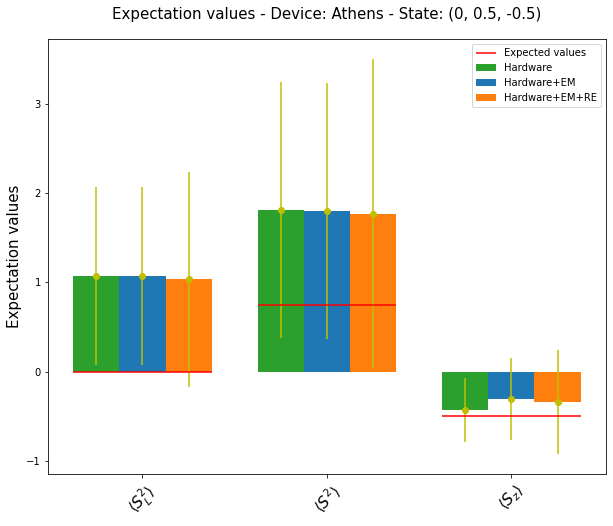

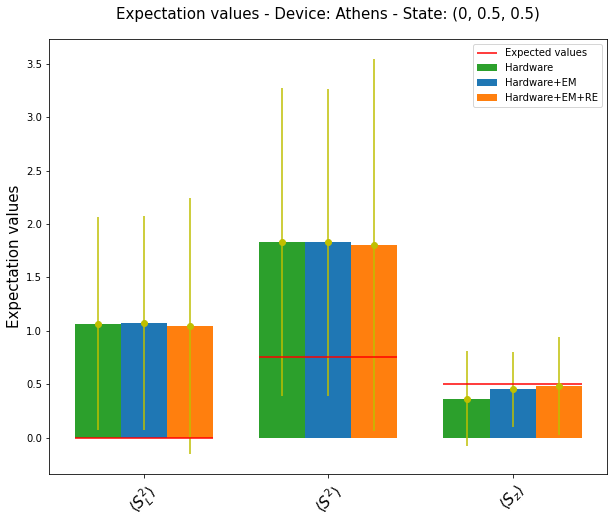

In [25]:
# Definition of straight line
def straight_line(x,m,q):
    return m*x+q

mat_op = []
mat_op.append(op_sl2.to_matrix())
mat_op.append(op_s2.to_matrix())
mat_op.append(op_sz.to_matrix())

s = 8192    # Number of shots

for i in range(2):
    data_raw, data_1, data_3, data_5, data_re = [], [], [], [], []
    err_raw, err_1, err_3, err_5, err_re = [], [], [], [], []
    
    for j in range(3):
        data_raw.append(np.trace(rho_fit[i][0]*mat_op[j]))
        data_1.append(np.trace(rho_fit[i][1]*mat_op[j]))
        data_3.append(np.trace(rho_fit[i][2]*mat_op[j]))
        data_5.append(np.trace(rho_fit[i][3]*mat_op[j]))
        
        err_raw.append(np.sqrt((np.trace(rho_fit[i][0]*np.dot(mat_op[j],mat_op[j])) - np.trace(rho_fit[i][0]*mat_op[j])**2)))
        err_1.append(np.sqrt((np.trace(rho_fit[i][1]*np.dot(mat_op[j],mat_op[j])) - np.trace(rho_fit[i][1]*mat_op[j])**2)))
        err_3.append(np.sqrt((np.trace(rho_fit[i][2]*np.dot(mat_op[j],mat_op[j])) - np.trace(rho_fit[i][2]*mat_op[j])**2)))
        err_5.append(np.sqrt((np.trace(rho_fit[i][3]*np.dot(mat_op[j],mat_op[j])) - np.trace(rho_fit[i][3]*mat_op[j])**2)))
        
    for k in range(len(data_1)):
        p_ave, p_cov = curve_fit(straight_line,[1,3,5],np.real([data_1[k],data_3[k],data_5[k]]),sigma=np.real([err_1[k],err_3[k],err_5[k]]),absolute_sigma=True)
        data_re.append(p_ave[1])
        err_re.append(np.sqrt(p_cov[1,1]))
    
    # The histograms - Plot of expectation values
    l=lab_list[i]
    fig, ax = plt.subplots(figsize=(10,8))
    x_lab=np.arange(3)
    width=0.25

    rects1 = ax.bar(x_lab - width, data_raw, width, label='Hardware',color='tab:green')
    ax.errorbar(x_lab - width,data_raw,yerr=err_raw,fmt='o',color='y')
    
    rects2 = ax.bar(x_lab, data_1, width, label='Hardware+EM',color='tab:blue')
    ax.errorbar(x_lab,data_1,yerr=err_1,fmt='o',color='y')
    
    rects3 = ax.bar(x_lab + width, data_re, width, label='Hardware+EM+RE',color='tab:orange')
    ax.errorbar(x_lab + width,data_re,yerr=err_re,fmt='o',color='y')
    
    ax.hlines(y=l[0]*(l[0]+1), xmin=0-3*width/2, xmax=0+3*width/2,colors="r")
    ax.hlines(y=l[1]*(l[1]+1), xmin=1-3*width/2, xmax=1+3*width/2,colors="r")
    ax.hlines(y=l[2], xmin=2-3*width/2, xmax=2+3*width/2,colors="r",label="Expected values")

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Expectation values',fontsize=15)
    ax.set_title(r'Expectation values - Device: Athens - State: '+str(l),fontsize=15,pad=20)
    ax.set_xticks(x_lab)
    ax.set_xticklabels([r"$\langle S_L^2 \rangle $", r"$\langle S^2 \rangle $", r"$\langle S_z \rangle $"],rotation=45,size=15)
    ax.legend()
    plt.show()

### $|s_L=1,s=1/2,s_z=\pm 1/2 \rangle$
#### Expectation values and Richardson extrapolation analysis

The RE results have been obtained using the CNOT multiplication method and considering the data corresponding to $N_{CNOT}=1,3,5$.

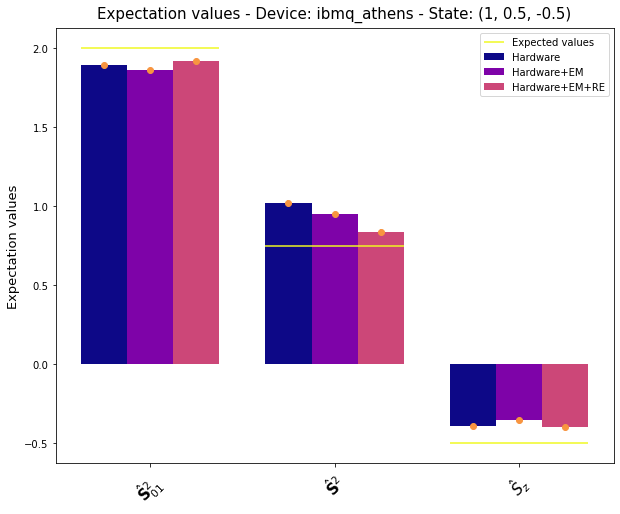

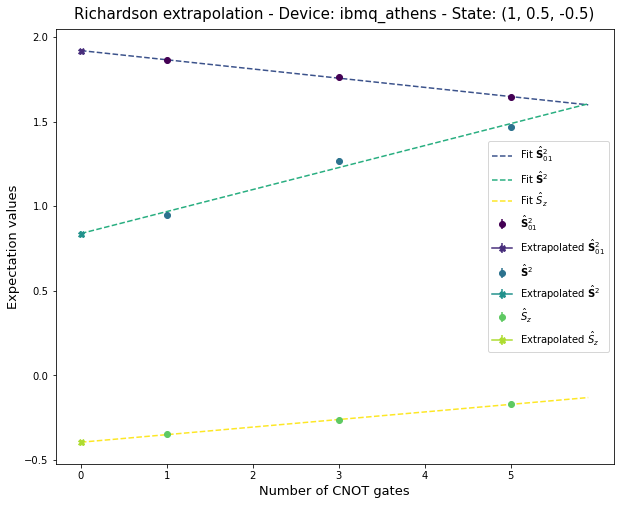

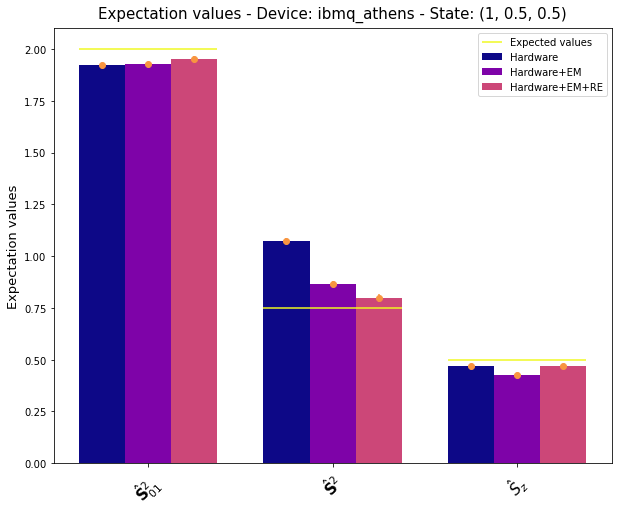

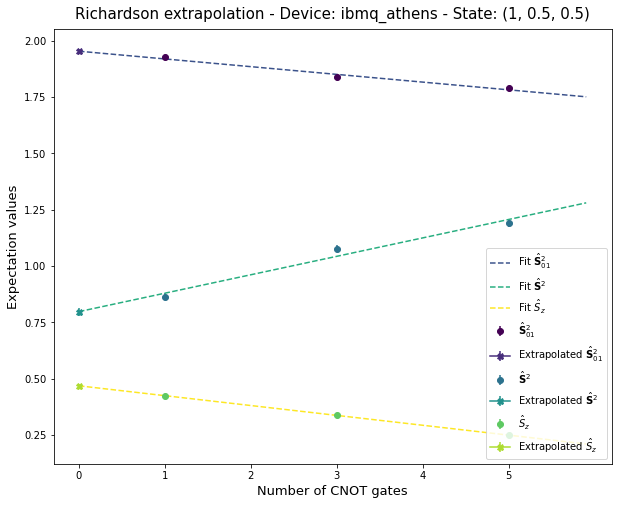

In [14]:
# Definition of straight line
def straight_line(x,m,q):
    return m*x+q

file = open("Results/VQE_spin_hardware_ry2.out")      # Before: VQE_spin_qasm_2.out
line = file.readlines()
line_val = []
for el in line:
    el2 = el.split()
    if el2[0]!="Job":
        line_val.append(el2)

s= 8192     # Number of shots
cl=0        # Count lines
for i in range(2):
    data_raw,err_raw=[],[]
    data_1,err_1=[],[]
    data_3,err_3=[],[]
    data_5,err_5=[],[]
    data_re,err_re=[],[]
    for j in range(15):
        val = line_val[cl]
        if j<3:
            data_raw.append(float(val[0]))
            err_raw.append(float(val[1]))    # Standard deviation!
        elif j>=3 and j<6:
            data_1.append(float(val[0]))
            err_1.append(float(val[1]))    # Standard deviation!
        elif j>=6 and j<9:
            data_3.append(float(val[0]))
            err_3.append(float(val[1]))    # Standard deviation!
        elif j>=9 and j<12:
            data_5.append(float(val[0]))
            err_5.append(float(val[1]))    # Standard deviation!
        #elif j>=12 and j<15:
        #    data_re.append(float(val[0]))
        #    err_re.append(np.sqrt(float(val[1])/s))    # Standard deviation!
        cl+=1
    
    for k in range(len(data_1)):
        #print([data_1[k],data_3[k],data_5[k]])
        p_ave, p_cov = curve_fit(straight_line,[1,3,5],[data_1[k],data_3[k],data_5[k]],sigma=[err_1[k],err_3[k],err_5[k]],absolute_sigma=True)
        data_re.append(p_ave[1])
        err_re.append(np.sqrt(p_cov[1,1]))
                                                                                                                                                                  
    # The histograms - Plot of expectation values
    op_labels=[r"$\hat{\mathbf{S}}_{01}^2$",r"$\hat{\mathbf{S}}^2$",r"$\hat{S}_z$"]
    
    jet = plt.get_cmap('plasma')
    colors = iter(jet(np.linspace(0,1,5)))
    
    l = lab_list[i+2]
    fig, ax = plt.subplots(figsize=(10,8))
    x_lab=np.arange(3)
    width=0.25

    rects1 = ax.bar(x_lab - width, data_raw, width, label='Hardware',color=next(colors))
    rects2 = ax.bar(x_lab, data_1, width, label='Hardware+EM',color=next(colors))
    rects3 = ax.bar(x_lab + width, data_re, width, label='Hardware+EM+RE',color=next(colors))
    
    c = next(colors)
    ax.errorbar(x_lab - width,data_raw,yerr=err_raw,fmt='o',color=c)
    ax.errorbar(x_lab,data_1,yerr=err_1,fmt='o',color=c)
    ax.errorbar(x_lab + width,data_re,yerr=err_re,fmt='o',color=c)
    
    c = next(colors)
    ax.hlines(y=l[0]*(l[0]+1), xmin=0-3*width/2, xmax=0+3*width/2,colors=c)
    ax.hlines(y=l[1]*(l[1]+1), xmin=1-3*width/2, xmax=1+3*width/2,colors=c)
    ax.hlines(y=l[2], xmin=2-3*width/2, xmax=2+3*width/2,colors=c,label="Expected values")

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Expectation values',fontsize=13)
    ax.set_title(r'Expectation values - Device: ibmq_athens - State: '+str(l),fontsize=15,pad=10)
    ax.set_xticks(x_lab)
    ax.set_xticklabels(op_labels,rotation=45,size=15)
    ax.legend()
    if i==0:
        plt.savefig("/Users/Alecoal/Desktop/Tesi/Text_Thesis/Pictures/RY_hardware_3_"+str(i+2)+".pdf")
    
    
    # Richardson extrapolation analysis
    jet = plt.get_cmap('viridis')
    colors = iter(jet(np.linspace(0,1,9)))
    
    plt.figure(figsize=(10,8))
    for j in range(3):
        # Data
        plt.errorbar([1,3,5],[data_1[j],data_3[j],data_5[j]],yerr=[err_1[j],err_3[j],err_5[j]],marker='o',ls="none",label=op_labels[j],color=next(colors))
        # Extrapolated data
        p_ave,p_cov = curve_fit(straight_line,[1,3,5],[data_1[j],data_3[j],data_5[j]],sigma=[err_1[j],err_3[j],err_5[j]],absolute_sigma=True)                                                                                    
        plt.errorbar([0],[p_ave[1]],yerr=[np.sqrt(p_cov[1,1])],marker='X',label='Extrapolated '+op_labels[j],color=next(colors))
        # Fit
        u = list(np.arange(0,6,0.1))
        v = [straight_line(ui,p_ave[0],p_ave[1]) for ui in u]
        plt.plot(u,v,'--',label='Fit '+op_labels[j], color=next(colors))                                                                                    
    
    plt.title("Richardson extrapolation - Device: ibmq_athens - State: "+str(l),size=15,pad=10)
    plt.xlabel("Number of CNOT gates",size=13)
    plt.xticks(np.arange(6))
    plt.ylabel("Expectation values",size=13)
    plt.legend()
    if i==0:
        plt.savefig("/Users/Alecoal/Desktop/Tesi/Text_Thesis/Pictures/RY_hardware_3_RE_"+str(i+2)+".pdf")

#### $|s_L=1,s=1/2,s_z=\pm 1/2 \rangle$:  Cost function and fidelities of the optimal circuits (computed with state tomography)

In [38]:
cl=30

psi_1= Zero(3)
#Here we define the circuit upon initial state assumption
var_form  = RealAmplitudes(3,initial_state=psi_1,entanglement=[(0,1),(1,2)],insert_barriers=True,reps=3)
#print("Number of parameters: "+str(var_form.num_parameters))

rho_fit_mit = []

for i in range(2):
    print("State label: ",lab_list[i+2])
    for j in range(2):
        param=[]
        if j==0:
            print("       Hardware results")
        if j==1:
            print("       Hardware + error mitigation results")
        for k in range(13):
            val = line_val[cl]
            if k==0:
                print("              C(s_L,s_s_z) = ",val[0])
            else:
                param.append(float(val[0]))
            cl+=1
        
        best_circ = var_form.assign_parameters(param)          # With RealAmplitudes/TwoLocal
        #best_circ = var_form.construct_circuit(param)         # With VariationalForm
        best_psi = CircuitStateFn(best_circ).to_matrix()
        # The best state
        #print("          | optimal circuit > = ",to_ket(best_psi))
        
        # STATE TOMOGRAPHY only for mitigated results
        if j==1:
            # Generate the state tomography circuit
            tomo_circ = state_tomography_circuits(best_circ,[0,1,2])
            # Execute
            job = qiskit.execute(tomo_circ, device, shots=8192)
            # Fit result
            tomo_fitter = StateTomographyFitter(job.result(), tomo_circ)
            # Perform the tomography fit which outputs a density matrix
            rho_fit_mit.append(tomo_fitter.fit(method='lstsq'))  
            fid_mit = qiskit.quantum_info.state_fidelity(rho_fit_mit[i], target_state[i+2])
            print('              State fidelity (tomography with readout error mitigation): F = {:.5f}'.format(fid_mit))

State label:  (1, 0.5, -0.5)
       Hardware results
              C(s_L,s_s_z) =  0.14069107695999214
       Hardware + error mitigation results
              C(s_L,s_s_z) =  0.0985871986538215
              State fidelity (tomography with readout error mitigation): F = 0.31726
State label:  (1, 0.5, 0.5)
       Hardware results
              C(s_L,s_s_z) =  0.08605956121508211
       Hardware + error mitigation results
              C(s_L,s_s_z) =  0.021927093863023668
              State fidelity (tomography with readout error mitigation): F = 0.28749


#### $|s_L=1,s=1/2,s_z= \pm 1/2 \rangle$:Fidelities of the optimal circuits (computed with the corresponding circuit matrix)

In [14]:
cl=30

psi_1= Zero(3)
#Here we define the circuit upon initial state assumption
var_form  = RealAmplitudes(3,initial_state=psi_1,entanglement=[(0,1),(1,2)],insert_barriers=True,reps=3)
#print("Number of parameters: "+str(var_form.num_parameters))

v0 = [0]*nqubits
v0[0] = 1

for i in range(2):
    print("State label: ",lab_list[i+2])
    for j in range(2):
        param=[]
        if j==0:
            print("       Hardware results")
        if j==1:
            print("       Hardware + readout error mitigation results")
        for k in range(13):
            val=line_val[cl]
            if k==0:
                c = val[0]
                #print("              C(s_L,s,s_z) = ",c)
            else:
                param.append(float(val[0]))
            cl+=1
        
        best_circ = var_form.assign_parameters(param)          # With RealAmplitudes/TwoLocal
        #best_circ = var_form.construct_circuit(param)         # With VariationalForm
        best_psi = CircuitStateFn(best_circ).to_matrix()
        best_ket = to_ket(best_psi)
        #print(best_ket)
        
        # Fidelity 
        fid = np.abs(np.dot(np.conj(eig_3spins[i+2]),best_psi))**2
        print("              Fidelity: F = ",fid)

State label:  (1, 0.5, -0.5)
       Hardware results
              Fidelity: F =  0.2962482359983704
       Hardware + readout error mitigation results
              Fidelity: F =  0.11080945981197104
State label:  (1, 0.5, 0.5)
       Hardware results
              Fidelity: F =  0.2585723492342272
       Hardware + readout error mitigation results
              Fidelity: F =  0.1888765668565231


#### Summary table on FIDELITIES

**EM** = (Readout) Error Mitigation

Statevector is used to refer to the matric which comes from the circuit conversion to the 2D-array.

|State label| Tomography (with EM)| Statevector  | Statevector (with EM) |
| :-: | :-: | :-: | :-: |
|<img width=150/>|<img width=100/>|<img width=100/>|<img width=100/>|
|$(1,1/2,-1/2)$ | $0.31726$ | $0.29625$ | $0.11081$ |  
|$(1,1/2,1/2)$ | $0.28749$ | $0.25857$ | $0.18888$ |

#### Expectation values on spin operators using $\text{Tr}(\rho \hat{O})$

Given the usual spin operators $\{\hat{S}_L^2,\hat{S}^2,\hat{S}_z\}$, we compute the expectation values on the optimal circuits of the VQE using the trace rule. $\rho$ is computed using the state tomography on `ibmq_athens` hardware.

The following array `rho_fit` will contain the density matrices of:
- raw data
- mitigated data with 1 CNOT
- mitigated data with 3 CNOTs
- mitigated data with 5 CNOTs

In [19]:
cl=30

psi_1= Zero(3)
#Here we define the circuit upon initial state assumption
var_form  = RealAmplitudes(3,initial_state=psi_1,entanglement=[(0,1),(1,2)],insert_barriers=True,reps=3)
#print("Number of parameters: "+str(var_form.num_parameters))

rho_fit = [[] for i in range(2)]
best_circ = [[] for i in range(2)]

for i in range(2):
    #print("State label: ",lab_list[i+2])
    for j in range(2):
        param = []
        for k in range(13):
            val = line_val[cl]
            if k==0:
                cost = val[0]
                #print("              C(s_L,s,s_z) = ",cost)
            else:
                param.append(float(val[0]))
            cl+=1
        
        best_circ[i].append(var_form.assign_parameters(param))          # With RealAmplitudes/TwoLocal
        
        # DENSITY MATRICES with TOMOGRAPHY
        # Generate the state tomography circuit
        tomo_circ = state_tomography_circuits(best_circ[i][j],[0,1,2])
        # Execute
        job = qiskit.execute(tomo_circ, device, shots=8192)
        # Fit result
        tomo_fitter = StateTomographyFitter(job.result(), tomo_circ)
        # Perform the tomography fit which outputs a density matrix
        rho_fit[i].append(tomo_fitter.fit(method='lstsq'))  
        
        # Adding the circuits and the corresponding density matrices of mitigated data with 3 and 5 CNOTs
        if j==1:
            for c in [3,5]:
                 # Multiplication of CNOT and CH gates by c=3/5
                qr      = QuantumRegister(nqubits,'q')
                circ_R  = QuantumCircuit(qr)
                
                for g in best_circ[i][1]: # loop over gates in circ
                    instruction,qubits,_ = g # extract gate info (domain: q1,q2 -- instruction)
                    #print(instruction.name)
                    if(instruction.name=='cx'): # if cnot, replicate
                        for k in range(c):
                            circ_R.cx(qubits[0],qubits[1]); circ_R.barrier()
                    elif(instruction.name=='u3'): # if u3, copy and paste
                        t1,t2,t3 = instruction.params
                        circ_R.u3(t1,t2,t3,qubits[0])
                    elif(instruction.name=='x'):  # if x, copy and paste
                        circ_R.x(qubits[0])
                    elif(instruction.name=='ry'): # if ry, copy and paste
                        t1 = instruction.params[0]
                        circ_R.ry(t1,qubits[0])
                    elif(instruction.name=='ch'): # if ch, replicate
                        for k in range(c):
                            circ_R.ch(qubits[0],qubits[1]); circ_R.barrier()
                    #else:
                    #    print("!!! ",instruction.name)

                #print(circ_R.draw())
                
                # DENSITY MATRICES with TOMOGRAPHY
                # Generate the state tomography circuit
                tomo_circ = state_tomography_circuits(circ_R,[0,1,2])
                # Execute
                job = qiskit.execute(tomo_circ, device, shots=8192)
                # Fit result
                tomo_fitter = StateTomographyFitter(job.result(), tomo_circ)
                # Perform the tomography fit which outputs a density matrix
                rho_fit[i].append(tomo_fitter.fit(method='lstsq'))  

We compute the expectation values and the variance of the given operators using:

$$\langle \hat{O} \rangle = \text{Tr}\{\rho \hat{O}\} \, , \quad \quad \sigma^2(\hat{O},\rho) = \langle \hat{O}^2 \rangle_\rho - \langle \hat{O} \rangle_\rho^2 = \text{Tr}\{\rho \hat{O}^2\} - \text{Tr}\{\rho \hat{O}\}^2$$

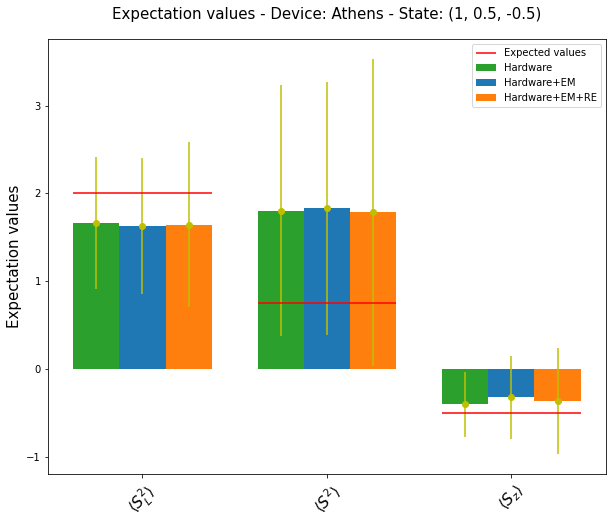

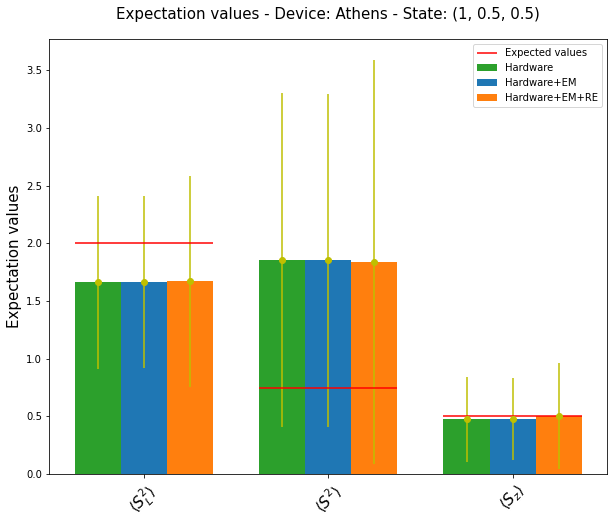

In [22]:
# Definition of straight line
def straight_line(x,m,q):
    return m*x+q

mat_op = []
mat_op.append(op_sl2.to_matrix())
mat_op.append(op_s2.to_matrix())
mat_op.append(op_sz.to_matrix())

s = 8192    # Number of shots

for i in range(2):
    data_raw, data_1, data_3, data_5, data_re = [], [], [], [], []
    err_raw, err_1, err_3, err_5, err_re = [], [], [], [], []
    
    for j in range(3):
        data_raw.append(np.trace(rho_fit[i][0]*mat_op[j]))
        data_1.append(np.trace(rho_fit[i][1]*mat_op[j]))
        data_3.append(np.trace(rho_fit[i][2]*mat_op[j]))
        data_5.append(np.trace(rho_fit[i][3]*mat_op[j]))
        
        err_raw.append(np.sqrt((np.trace(rho_fit[i][0]*np.dot(mat_op[j],mat_op[j])) - np.trace(rho_fit[i][0]*mat_op[j])**2)))
        err_1.append(np.sqrt((np.trace(rho_fit[i][1]*np.dot(mat_op[j],mat_op[j])) - np.trace(rho_fit[i][1]*mat_op[j])**2)))
        err_3.append(np.sqrt((np.trace(rho_fit[i][2]*np.dot(mat_op[j],mat_op[j])) - np.trace(rho_fit[i][2]*mat_op[j])**2)))
        err_5.append(np.sqrt((np.trace(rho_fit[i][3]*np.dot(mat_op[j],mat_op[j])) - np.trace(rho_fit[i][3]*mat_op[j])**2)))
        
    for k in range(len(data_1)):
        p_ave, p_cov = curve_fit(straight_line,[1,3,5],np.real([data_1[k],data_3[k],data_5[k]]),sigma=np.real([err_1[k],err_3[k],err_5[k]]),absolute_sigma=True)
        data_re.append(p_ave[1])
        err_re.append(np.sqrt(p_cov[1,1]))
    
    # The histograms - Plot of expectation values
    l=lab_list[i+2]
    fig, ax = plt.subplots(figsize=(10,8))
    x_lab=np.arange(3)
    width=0.25

    rects1 = ax.bar(x_lab - width, data_raw, width, label='Hardware',color='tab:green')
    ax.errorbar(x_lab - width,data_raw,yerr=err_raw,fmt='o',color='y')
    
    rects2 = ax.bar(x_lab, data_1, width, label='Hardware+EM',color='tab:blue')
    ax.errorbar(x_lab,data_1,yerr=err_1,fmt='o',color='y')
    
    rects3 = ax.bar(x_lab + width, data_re, width, label='Hardware+EM+RE',color='tab:orange')
    ax.errorbar(x_lab + width,data_re,yerr=err_re,fmt='o',color='y')
    
    ax.hlines(y=l[0]*(l[0]+1), xmin=0-3*width/2, xmax=0+3*width/2,colors="r")
    ax.hlines(y=l[1]*(l[1]+1), xmin=1-3*width/2, xmax=1+3*width/2,colors="r")
    ax.hlines(y=l[2], xmin=2-3*width/2, xmax=2+3*width/2,colors="r",label="Expected values")

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Expectation values',fontsize=15)
    ax.set_title(r'Expectation values - Device: Athens - State: '+str(l),fontsize=15,pad=20)
    ax.set_xticks(x_lab)
    ax.set_xticklabels([r"$\langle S_L^2 \rangle $", r"$\langle S^2 \rangle $", r"$\langle S_z \rangle $"],rotation=45,size=15)
    ax.legend()
    plt.show()

###  $|s_L=1,s=3/2,s_z=-3/2,-1/2,1/2,3/2 \rangle$ ( last $4$ circuits)
#### Expectation values and Richardson extrapolation analysis

The RE results have been obtained using the CNOT multiplication method and considering the data corresponding to $N_{CNOT}=1,3,5$.

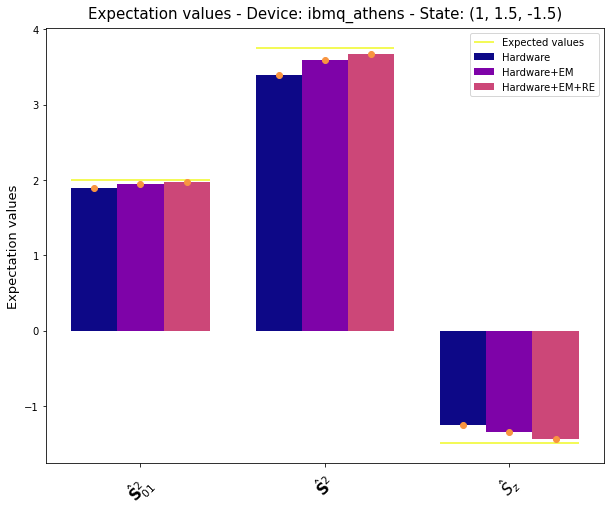

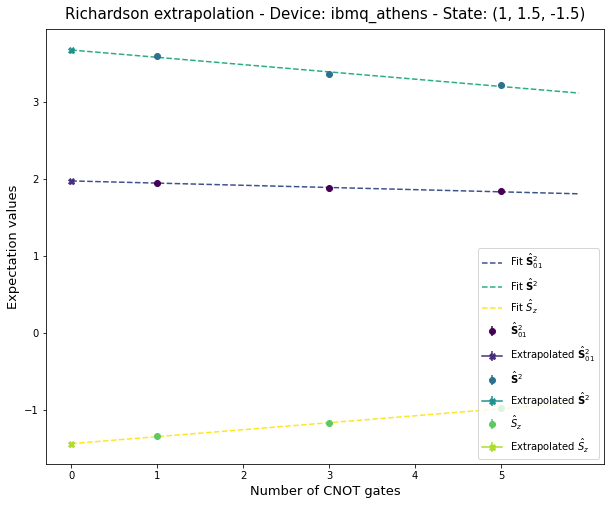

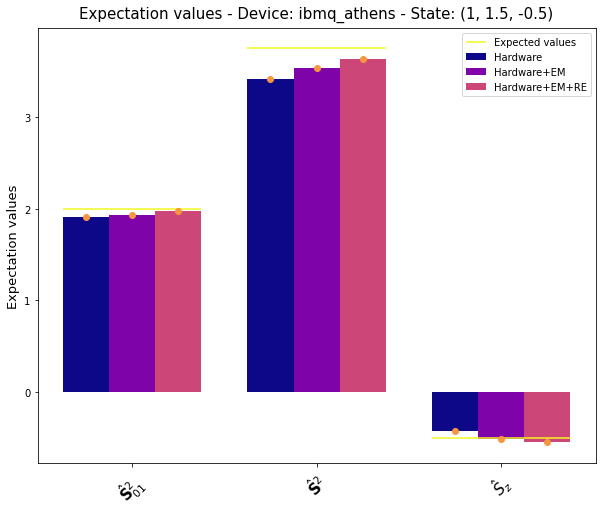

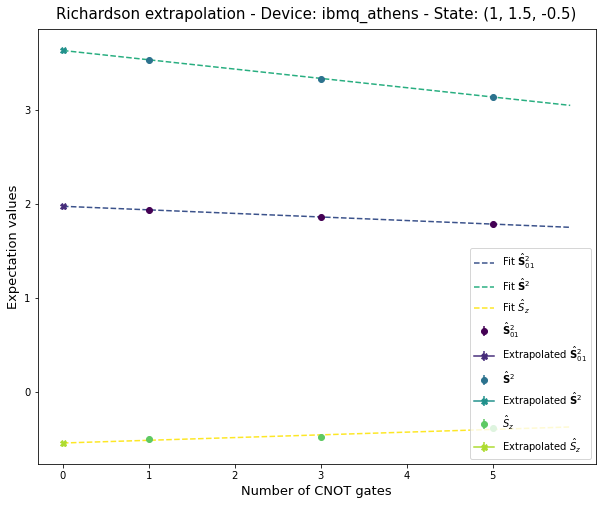

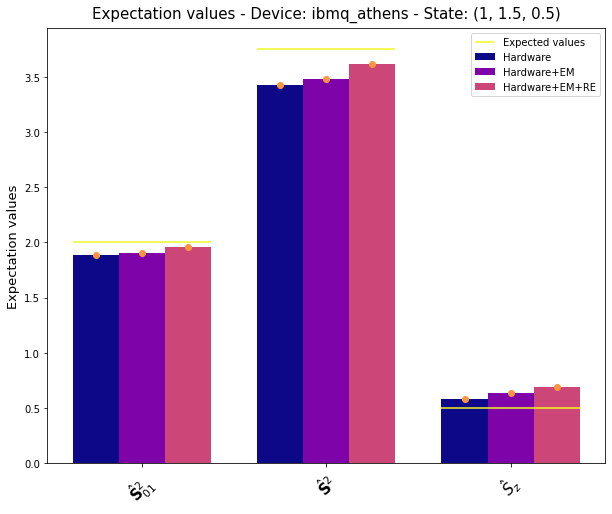

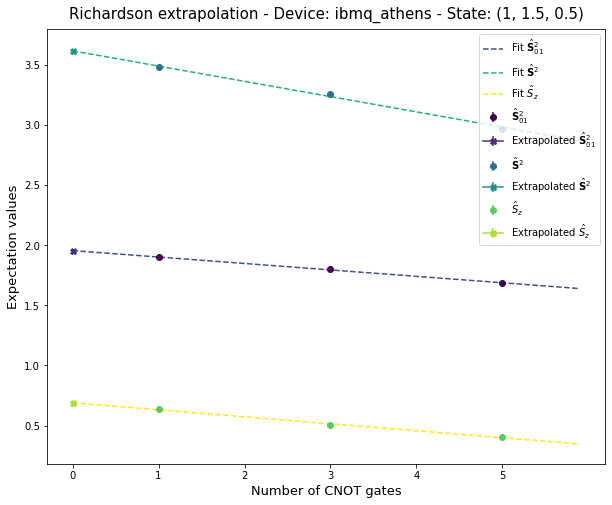

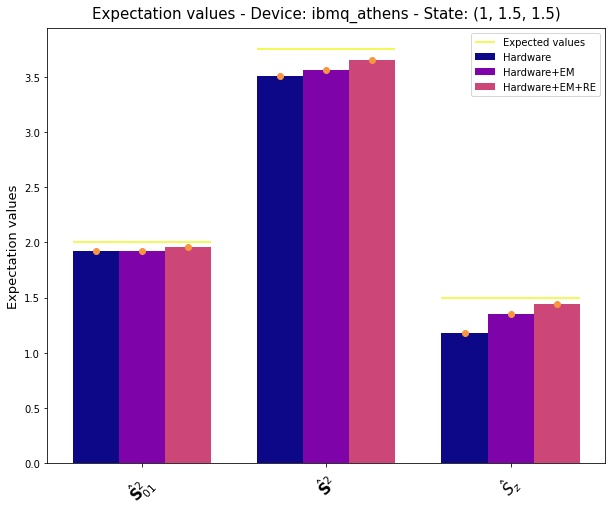

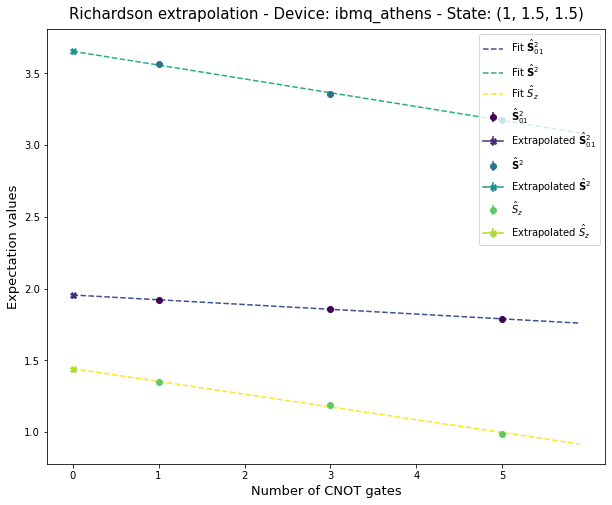

In [13]:
# Definition of straight line
def straight_line(x,m,q):
    return m*x+q

file=open("Results/VQE_spin_hardware_ry3.out")      # Before: VQE_spin_qasm_2.out
line=file.readlines()
line_val = []
for el in line:
    el2 = el.split()
    if el2[0]!="Job":
        line_val.append(el2)

s= 8192     # Number of shots
cl=0        # Count lines
for i in range(4):
    data_raw,err_raw=[],[]
    data_1,err_1=[],[]
    data_3,err_3=[],[]
    data_5,err_5=[],[]
    data_re,err_re=[],[]
    for j in range(15):
        val = line_val[cl]
        if j<3:
            data_raw.append(float(val[0]))
            err_raw.append(float(val[1]))    # Standard deviation!
        elif j>=3 and j<6:
            data_1.append(float(val[0]))
            err_1.append(float(val[1]))    # Standard deviation!
        elif j>=6 and j<9:
            data_3.append(float(val[0]))
            err_3.append(float(val[1]))    # Standard deviation!
        elif j>=9 and j<12:
            data_5.append(float(val[0]))
            err_5.append(float(val[1]))    # Standard deviation!
        #elif j>=12 and j<15:
        #    data_re.append(float(val[0]))
        #    err_re.append(np.sqrt(float(val[1])/s))    # Standard deviation!
        cl+=1
    
    for k in range(len(data_1)):
        #print([data_1[k],data_3[k],data_5[k]])
        p_ave, p_cov = curve_fit(straight_line,[1,3,5],[data_1[k],data_3[k],data_5[k]],sigma=[err_1[k],err_3[k],err_5[k]],absolute_sigma=True)
        data_re.append(p_ave[1])
        err_re.append(np.sqrt(p_cov[1,1]))
                                                                                                                                                                  
    # The histograms - Plot of expectation values
    op_labels=[r"$\hat{\mathbf{S}}_{01}^2$",r"$\hat{\mathbf{S}}^2$",r"$\hat{S}_z$"]
    
    jet = plt.get_cmap('plasma')
    colors = iter(jet(np.linspace(0,1,5)))
    
    l = lab_list[i+4]
    fig, ax = plt.subplots(figsize=(10,8))
    x_lab=np.arange(3)
    width=0.25

    rects1 = ax.bar(x_lab - width, data_raw, width, label='Hardware',color=next(colors))
    rects2 = ax.bar(x_lab, data_1, width, label='Hardware+EM',color=next(colors))
    rects3 = ax.bar(x_lab + width, data_re, width, label='Hardware+EM+RE',color=next(colors))
    
    c = next(colors)
    ax.errorbar(x_lab - width,data_raw,yerr=err_raw,fmt='o',color=c)
    ax.errorbar(x_lab,data_1,yerr=err_1,fmt='o',color=c)
    ax.errorbar(x_lab + width,data_re,yerr=err_re,fmt='o',color=c)
    
    c = next(colors)
    ax.hlines(y=l[0]*(l[0]+1), xmin=0-3*width/2, xmax=0+3*width/2,colors=c)
    ax.hlines(y=l[1]*(l[1]+1), xmin=1-3*width/2, xmax=1+3*width/2,colors=c)
    ax.hlines(y=l[2], xmin=2-3*width/2, xmax=2+3*width/2,colors=c,label="Expected values")

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Expectation values',fontsize=13)
    ax.set_title(r'Expectation values - Device: ibmq_athens - State: '+str(l),fontsize=15,pad=10)
    ax.set_xticks(x_lab)
    ax.set_xticklabels(op_labels,rotation=45,size=15)
    ax.legend()
    if i==1:
        plt.savefig("/Users/Alecoal/Desktop/Tesi/Text_Thesis/Pictures/RY_hardware_3_"+str(i+4)+".pdf")
    
    # Richardson extrapolation analysis
    jet = plt.get_cmap('viridis')
    colors = iter(jet(np.linspace(0,1,9)))
    
    plt.figure(figsize=(10,8))
    for j in range(3):
        # Data
        plt.errorbar([1,3,5],[data_1[j],data_3[j],data_5[j]],yerr=[err_1[j],err_3[j],err_5[j]],marker='o',ls="none",label=op_labels[j],color=next(colors))
        # Extrapolated data
        p_ave,p_cov = curve_fit(straight_line,[1,3,5],[data_1[j],data_3[j],data_5[j]],sigma=[err_1[j],err_3[j],err_5[j]],absolute_sigma=True)                                                                                    
        plt.errorbar([0],[p_ave[1]],yerr=[np.sqrt(p_cov[1,1])],marker='X',label='Extrapolated '+op_labels[j],color=next(colors))
        # Fit
        u = list(np.arange(0,6,0.1))
        v = [straight_line(ui,p_ave[0],p_ave[1]) for ui in u]
        plt.plot(u,v,'--',label='Fit '+op_labels[j], color=next(colors))                                                                                    
    
    plt.title("Richardson extrapolation - Device: ibmq_athens - State: "+str(l),size=15,pad=10)
    plt.xlabel("Number of CNOT gates",size=13)
    plt.xticks(np.arange(6))
    plt.ylabel("Expectation values",size=13)
    plt.legend()
    if i==1:
        plt.savefig("/Users/Alecoal/Desktop/Tesi/Text_Thesis/Pictures/RY_hardware_3_RE_"+str(i+4)+".pdf")

#### $|s_L=1,s=3/2,s_z= \pm 3/2,\pm 1/2 \rangle$: Fidelities of the optimal circuits (computed with state tomography)

In [40]:
cl=60

psi_1= Zero(3)
#Here we define the circuit upon initial state assumption
var_form  = RealAmplitudes(3,initial_state=psi_1,entanglement=[(0,1),(1,2)],insert_barriers=True,reps=3)
#print("Number of parameters: "+str(var_form.num_parameters))

rho_fit_mit = []

for i in range(4):
    print("State label: ",lab_list[i+4])
    for j in range(2):
        param=[]
        if j==0:
            print("       Hardware results")
        if j==1:
            print("       Hardware + error mitigation results")
        for k in range(13):
            val=line_val[cl]
            if k==0:
                print("              C(s_L,s_s_z) = ",val[0])
            else:
                param.append(float(val[0]))
            cl+=1
        
        best_circ = var_form.assign_parameters(param)          # With RealAmplitudes/TwoLocal
        #best_circ = var_form.construct_circuit(param)         # With VariationalForm
        best_psi = CircuitStateFn(best_circ).to_matrix()
        # The best state
        #print("          | optimal > = ",to_ket(best_psi))
           
        # STATE TOMOGRAPHY only for mitigated results
        if j==1:
            # Generate the state tomography circuit
            tomo_circ = state_tomography_circuits(best_circ,[0,1,2])
            # Execute
            job = qiskit.execute(tomo_circ, device, shots=8192)
            # Fit result
            tomo_fitter = StateTomographyFitter(job.result(), tomo_circ)
            # Perform the tomography fit which outputs a density matrix
            rho_fit_mit.append(tomo_fitter.fit(method='lstsq'))  
            fid_mit = qiskit.quantum_info.state_fidelity(rho_fit_mit[i], target_state[i+4])
            print('              State fidelity (tomography with readout error mitigation): F = {:.5f}'.format(fid_mit))

State label:  (1, 1.5, -1.5)
       Hardware results
              C(s_L,s_s_z) =  0.17095428645710248
       Hardware + error mitigation results
              C(s_L,s_s_z) =  0.020778106713486358
              State fidelity (tomography with readout error mitigation): F = 0.85952
State label:  (1, 1.5, -0.5)
       Hardware results
              C(s_L,s_s_z) =  0.12588904379174873
       Hardware + error mitigation results
              C(s_L,s_s_z) =  0.08852194897715257
              State fidelity (tomography with readout error mitigation): F = 0.49393
State label:  (1, 1.5, 0.5)
       Hardware results
              C(s_L,s_s_z) =  0.170499921930914
       Hardware + error mitigation results
              C(s_L,s_s_z) =  0.07572536227628175
              State fidelity (tomography with readout error mitigation): F = 0.02291
State label:  (1, 1.5, 1.5)
       Hardware results
              C(s_L,s_s_z) =  0.16843431347707022
       Hardware + error mitigation results
              

As we expected the Dicke states, $|s_L=1,s=3/2,s_z=-1/2 \rangle$ and $|s_L=1,s=3/2,s_z=1/2 \rangle$, are hard to find both on classical and quantum simulations.

#### $|s_L=1,s=3/2,s_z= \pm 3/2,\pm 1/2 \rangle$: Fidelities of the optimal circuits (computed with the corresponding circuit matrix)

In [19]:
cl=60

psi_1= Zero(3)
#Here we define the circuit upon initial state assumption
var_form  = RealAmplitudes(3,initial_state=psi_1,entanglement=[(0,1),(1,2)],insert_barriers=True,reps=3)
#print("Number of parameters: "+str(var_form.num_parameters))

v0 = [0]*nqubits
v0[0] = 1

for i in range(4):
    print("State label: ",lab_list[i+4])
    for j in range(2):
        param=[]
        if j==0:
            print("       Hardware results")
        if j==1:
            print("       Hardware + readout error mitigation results")
        for k in range(13):
            val=line_val[cl]
            if k==0:
                c = val[0]
                #print("              C(s_L,s,s_z) = ",c)
            else:
                param.append(float(val[0]))
            cl+=1
        
        best_circ = var_form.assign_parameters(param)          # With RealAmplitudes/TwoLocal
        #best_circ = var_form.construct_circuit(param)         # With VariationalForm
        best_psi = CircuitStateFn(best_circ).to_matrix()
        best_ket = to_ket(best_psi)
        #print(best_ket)
        
        # Fidelity 
        fid = np.abs(np.dot(np.conj(eig_3spins[i+4]),best_psi))**2
        print("              Fidelity: F = ",fid)

State label:  (1, 1.5, -1.5)
       Hardware results
              Fidelity: F =  0.9965649447563503
       Hardware + readout error mitigation results
              Fidelity: F =  0.9932081956360512
State label:  (1, 1.5, -0.5)
       Hardware results
              Fidelity: F =  0.12938202262490706
       Hardware + readout error mitigation results
              Fidelity: F =  0.5671527119452596
State label:  (1, 1.5, 0.5)
       Hardware results
              Fidelity: F =  0.846476298518413
       Hardware + readout error mitigation results
              Fidelity: F =  3.768103946899105e-06
State label:  (1, 1.5, 1.5)
       Hardware results
              Fidelity: F =  0.8215869864310531
       Hardware + readout error mitigation results
              Fidelity: F =  0.9894979195042763


#### Summary table on FIDELITIES

**EM** = (Readout) Error Mitigation

Statevector is used to refer to the matrix which comes from the circuit conversion to the 2D-array.

|State label| Tomography (with EM)| Statevector  | Statevector (with EM) |
| :-: | :-: | :-: | :-: |
|<img width=150/>|<img width=100/>|<img width=100/>|<img width=100/>|
|$(1,3/2,-3/2)$ | $0.85952$ | $0.99656$ | $0.99321$ |  
|$(1,3/2,-1/2)$ | $0.49393$ | $0.12938$ | $0.56715$ |
|$(1,3/2, 1/2)$ | $0.02291$ | $0.84647$ | $3.8 \cdot 10^{-6}$ |
|$(1,3/2, 3/2)$ | $0.89360$ | $0.82159$ | $0.98950$ |

#### Expectation values on spin operators using $\text{Tr}(\rho \hat{O})$

Given the usual spin operators $\{\hat{S}_L^2,\hat{S}^2,\hat{S}_z\}$, we compute the expectation values on the optimal circuits of the VQE using the trace rule. $\rho$ is computed using the state tomography on `ibmq_athens` hardware.

The following array `rho_fit` will contain the density matrices of:
- raw data
- mitigated data with 1 CNOT
- mitigated data with 3 CNOTs
- mitigated data with 5 CNOTs

In [34]:
cl=60

psi_1= Zero(3)
#Here we define the circuit upon initial state assumption
var_form  = RealAmplitudes(3,initial_state=psi_1,entanglement=[(0,1),(1,2)],insert_barriers=True,reps=3)
#print("Number of parameters: "+str(var_form.num_parameters))

rho_fit = [[] for i in range(4)]
best_circ = [[] for i in range(4)]

for i in range(4):
    #print("State label: ",lab_list[i+4])
    for j in range(2):
        param = []
        for k in range(13):
            val = line_val[cl]
            if k==0:
                cost = val[0]
                #print("              C(s_L,s,s_z) = ",cost)
            else:
                param.append(float(val[0]))
            cl+=1
        
        best_circ[i].append(var_form.assign_parameters(param))          # With RealAmplitudes/TwoLocal
        
        # DENSITY MATRICES with TOMOGRAPHY
        # Generate the state tomography circuit
        tomo_circ = state_tomography_circuits(best_circ[i][j],[0,1,2])
        # Execute
        job = qiskit.execute(tomo_circ, device, shots=8192)
        # Fit result
        tomo_fitter = StateTomographyFitter(job.result(), tomo_circ)
        # Perform the tomography fit which outputs a density matrix
        rho_fit[i].append(tomo_fitter.fit(method='lstsq'))  
        
        # Adding the circuits and the corresponding density matrices of mitigated data with 3 and 5 CNOTs
        if j==1:
            for c in [3,5]:
                 # Multiplication of CNOT and CH gates by c=3/5
                qr      = QuantumRegister(nqubits,'q')
                circ_R  = QuantumCircuit(qr)
                
                for g in best_circ[i][1]: # loop over gates in circ
                    instruction,qubits,_ = g # extract gate info (domain: q1,q2 -- instruction)
                    #print(instruction.name)
                    if(instruction.name=='cx'): # if cnot, replicate
                        for k in range(c):
                            circ_R.cx(qubits[0],qubits[1]); circ_R.barrier()
                    elif(instruction.name=='u3'): # if u3, copy and paste
                        t1,t2,t3 = instruction.params
                        circ_R.u3(t1,t2,t3,qubits[0])
                    elif(instruction.name=='x'):  # if x, copy and paste
                        circ_R.x(qubits[0])
                    elif(instruction.name=='ry'): # if ry, copy and paste
                        t1 = instruction.params[0]
                        circ_R.ry(t1,qubits[0])
                    elif(instruction.name=='ch'): # if ch, replicate
                        for k in range(c):
                            circ_R.ch(qubits[0],qubits[1]); circ_R.barrier()
                    #else:
                    #    print("!!! ",instruction.name)

                #print(circ_R.draw())
                
                # DENSITY MATRICES with TOMOGRAPHY
                # Generate the state tomography circuit
                tomo_circ = state_tomography_circuits(circ_R,[0,1,2])
                # Execute
                job = qiskit.execute(tomo_circ, device, shots=8192)
                # Fit result
                tomo_fitter = StateTomographyFitter(job.result(), tomo_circ)
                # Perform the tomography fit which outputs a density matrix
                rho_fit[i].append(tomo_fitter.fit(method='lstsq'))  

We compute the expectation values and the variance of the given operators using:

$$\langle \hat{O} \rangle = \text{Tr}\{\rho \hat{O}\} \, , \quad \quad \sigma^2(\hat{O},\rho) = \langle \hat{O}^2 \rangle_\rho - \langle \hat{O} \rangle_\rho^2 = \text{Tr}\{\rho \hat{O}^2\} - \text{Tr}\{\rho \hat{O}\}^2$$

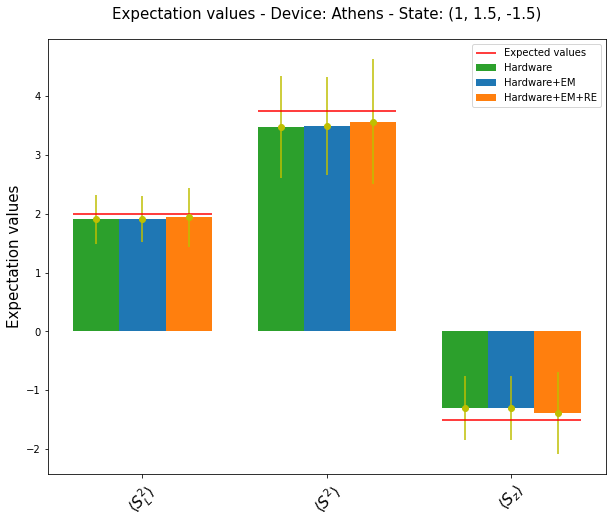

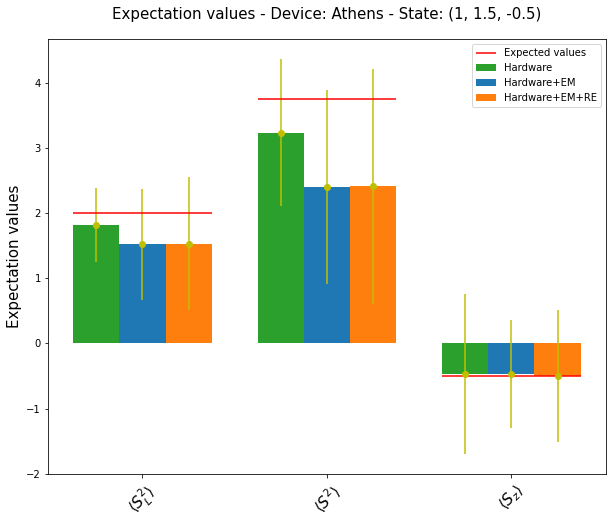

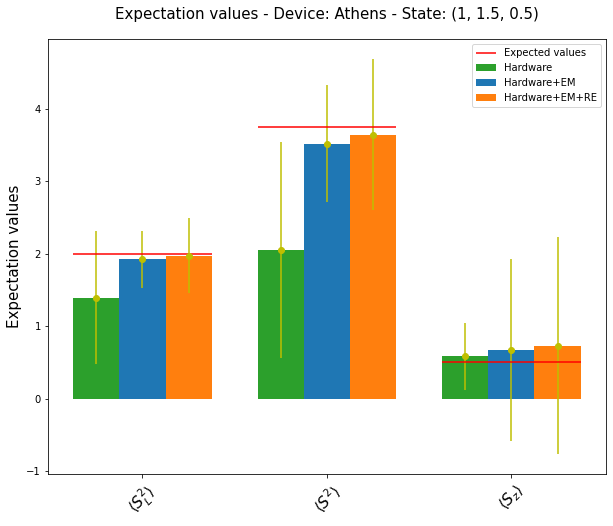

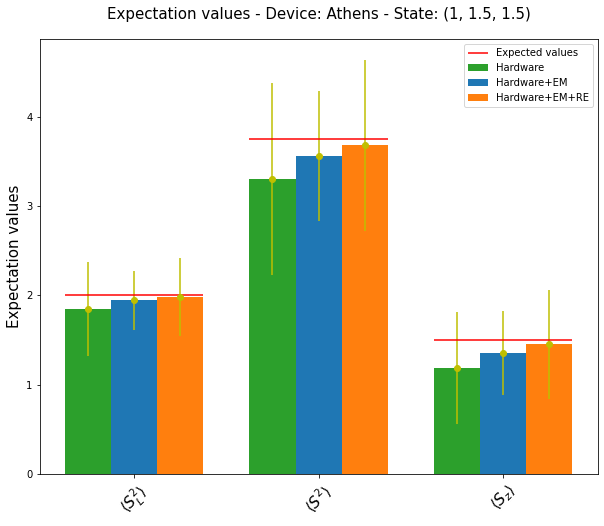

In [36]:
# Definition of straight line
def straight_line(x,m,q):
    return m*x+q

mat_op = []
mat_op.append(op_sl2.to_matrix())
mat_op.append(op_s2.to_matrix())
mat_op.append(op_sz.to_matrix())

s = 8192    # Number of shots

for i in range(4):
    data_raw, data_1, data_3, data_5, data_re = [], [], [], [], []
    err_raw, err_1, err_3, err_5, err_re = [], [], [], [], []
    
    for j in range(3):
        data_raw.append(np.trace(rho_fit[i][0]*mat_op[j]))
        data_1.append(np.trace(rho_fit[i][1]*mat_op[j]))
        data_3.append(np.trace(rho_fit[i][2]*mat_op[j]))
        data_5.append(np.trace(rho_fit[i][3]*mat_op[j]))
        
        err_raw.append(np.sqrt((np.trace(rho_fit[i][0]*np.dot(mat_op[j],mat_op[j])) - np.trace(rho_fit[i][0]*mat_op[j])**2)))
        err_1.append(np.sqrt((np.trace(rho_fit[i][1]*np.dot(mat_op[j],mat_op[j])) - np.trace(rho_fit[i][1]*mat_op[j])**2)))
        err_3.append(np.sqrt((np.trace(rho_fit[i][2]*np.dot(mat_op[j],mat_op[j])) - np.trace(rho_fit[i][2]*mat_op[j])**2)))
        err_5.append(np.sqrt((np.trace(rho_fit[i][3]*np.dot(mat_op[j],mat_op[j])) - np.trace(rho_fit[i][3]*mat_op[j])**2)))
        
    for k in range(len(data_1)):
        p_ave, p_cov = curve_fit(straight_line,[1,3,5],np.real([data_1[k],data_3[k],data_5[k]]),sigma=np.real([err_1[k],err_3[k],err_5[k]]),absolute_sigma=True)
        data_re.append(p_ave[1])
        err_re.append(np.sqrt(p_cov[1,1]))
    
    # The histograms - Plot of expectation values
    l=lab_list[i+4]
    fig, ax = plt.subplots(figsize=(10,8))
    x_lab=np.arange(3)
    width=0.25

    rects1 = ax.bar(x_lab - width, data_raw, width, label='Hardware',color='tab:green')
    ax.errorbar(x_lab - width,data_raw,yerr=err_raw,fmt='o',color='y')
    
    rects2 = ax.bar(x_lab, data_1, width, label='Hardware+EM',color='tab:blue')
    ax.errorbar(x_lab,data_1,yerr=err_1,fmt='o',color='y')
    
    rects3 = ax.bar(x_lab + width, data_re, width, label='Hardware+EM+RE',color='tab:orange')
    ax.errorbar(x_lab + width,data_re,yerr=err_re,fmt='o',color='y')
    
    ax.hlines(y=l[0]*(l[0]+1), xmin=0-3*width/2, xmax=0+3*width/2,colors="r")
    ax.hlines(y=l[1]*(l[1]+1), xmin=1-3*width/2, xmax=1+3*width/2,colors="r")
    ax.hlines(y=l[2], xmin=2-3*width/2, xmax=2+3*width/2,colors="r",label="Expected values")

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Expectation values',fontsize=15)
    ax.set_title(r'Expectation values - Device: Athens - State: '+str(l),fontsize=15,pad=20)
    ax.set_xticks(x_lab)
    ax.set_xticklabels([r"$\langle S_L^2 \rangle $", r"$\langle S^2 \rangle $", r"$\langle S_z \rangle $"],rotation=45,size=15)
    ax.legend()
    plt.show()

### Analysis of decomposition of $R_{xx}$, $R_{yy}$ and $R_{zz}$ gates

**Reference**: *Tacchino et al. - Quantum computers as universal quantum simulators: state-of-art and perspectives*

<img src="Pictures/Rxx.png" width="600">

<img src="Pictures/Ryy.png" width="600">

<img src="Pictures/Rzz.png" width="350">

#### Check

In [49]:
theta = np.pi*37

# Rzz
print("R_{zz}")
qc = QuantumCircuit(2)
qc.rzz(theta,0,1)
print(qc.draw())
M = Operator(qc).data
#print(M)

qc2 = QuantumCircuit(2)
qc2.cx(0,1)
qc2.rz(theta,1)
qc2.cx(0,1)
print(qc2.draw())
M2 = Operator(qc2).data
#print(M2)

if np.all(np.round(M,10)==np.round(M2,10)):
    print("\n","Matrices equal!")

# Rxx
print("\n","R_{xx}")
qc = QuantumCircuit(2)
qc.rxx(theta,0,1)
print(qc.draw())
M = Operator(qc).data
#print(M)

qc2 = QuantumCircuit(2)
qc2.ry(np.pi/2,[0,1])
qc2.cx(0,1)
qc2.rz(theta,1)
qc2.cx(0,1)
qc2.ry(-np.pi/2,[0,1])
print(qc2.draw())
M2 = Operator(qc2).data
#print(M2)

if np.all(np.round(M,10)==np.round(M2,10)):
    print("\n","Matrices equal!")

# Ryy
print("\n","R_{yy}")
qc = QuantumCircuit(2)
qc.ryy(theta,0,1)
print(qc.draw())
M = Operator(qc).data
#print(M)

qc2 = QuantumCircuit(2)
qc2.rx(np.pi/2,[0,1])
qc2.cx(0,1)
qc2.rz(theta,1)
qc2.cx(0,1)
qc2.rx(-np.pi/2,[0,1])
print(qc2.draw())
M2 = Operator(qc2).data
#print(M2)

if np.all(np.round(M,10)==np.round(M2,10)):
    print("\n","Matrices equal!")

R_{zz}
               
q_0: ─■────────
      │zz(37π) 
q_1: ─■────────
               
                          
q_0: ──■───────────────■──
     ┌─┴─┐┌─────────┐┌─┴─┐
q_1: ┤ X ├┤ RZ(37π) ├┤ X ├
     └───┘└─────────┘└───┘

 Matrices equal!

 R_{xx}
     ┌───────────┐
q_0: ┤0          ├
     │  RXX(37π) │
q_1: ┤1          ├
     └───────────┘
     ┌─────────┐                     ┌──────────┐
q_0: ┤ RY(π/2) ├──■───────────────■──┤ RY(-π/2) ├
     ├─────────┤┌─┴─┐┌─────────┐┌─┴─┐├──────────┤
q_1: ┤ RY(π/2) ├┤ X ├┤ RZ(37π) ├┤ X ├┤ RY(-π/2) ├
     └─────────┘└───┘└─────────┘└───┘└──────────┘

 Matrices equal!

 R_{yy}
     ┌───────────┐
q_0: ┤0          ├
     │  RYY(37π) │
q_1: ┤1          ├
     └───────────┘
     ┌─────────┐                     ┌──────────┐
q_0: ┤ RX(π/2) ├──■───────────────■──┤ RX(-π/2) ├
     ├─────────┤┌─┴─┐┌─────────┐┌─┴─┐├──────────┤
q_1: ┤ RX(π/2) ├┤ X ├┤ RZ(37π) ├┤ X ├┤ RX(-π/2) ├
     └─────────┘└───┘└─────────┘└───┘└──────────┘

 Matrices equal!


#### New variational forms

In [44]:
# 1 parameter for R_xx gates, 1 for R_yy and 1 for R_zz 
class EvolVarForm5(VariationalForm): # definition of a variational ansatz
    def __init__(self, num_qubits: Optional[int] = None, reps: int = 1,
                 connections: Union[str, List[int]] = 'full',
                 initial_state: Optional[InitialState] = None) -> None:
        super().__init__()
        self._num_qubits = num_qubits
        self._reps = reps
        self._initial_state = initial_state
        
        if(connections=='full'):
            self._connections = [(i,j) for i in range(num_qubits) for j in range(num_qubits) if j>i]
        elif(connections=='linear'):
            self._connections = [(i,i+1) for i in range(num_qubits-1)]
        else:
            self._connections = connections
        
        # Here the difference 
        self._num_parameters = self._reps*3
        
        self._bounds = [(-np.pi,np.pi)]*self._num_parameters

    @property
    def num_qubits(self) -> int:
        return self._num_qubits

    @num_qubits.setter
    def num_qubits(self, num_qubits: int) -> None:
        self._num_qubits = num_qubits

    # dati parametri theta, costruire un circuito che restituisce Psi(theta)

    def construct_circuit(self, parameters: Union[np.ndarray, List[Parameter], ParameterVector],
                          q: Optional[QuantumRegister] = None) -> QuantumCircuit:
        if len(parameters) != self._num_parameters:
            raise ValueError('The number of parameters has to be {}'.format(self._num_parameters))

        if self._num_qubits is None:
            raise ValueError('The number of qubits is None and must be set before the circuit '
                             'can be created.')

        if q is None:
            q = QuantumRegister(self._num_qubits, name='q')
        if self._initial_state is not None:
            circuit = self._initial_state.construct_circuit('circuit', q)
        else:
            circuit = QuantumCircuit(q)
        
        # In the following cycle the differences w.r.t. the previous EvolVarForm
        # c count the repetitions
        c=0
        for l in range(self._reps):
            if(l==0): # Special structure for 1st layer (no e^{-i epsilon H_0})
                for [i,j] in  self._connections:
                    if i==(self._num_qubits-1) or j==(self._num_qubits-1):
                        circuit.rxx(2*parameters[3*c+0],i,j)
                        circuit.ryy(2*parameters[3*c+1],i,j)
                        circuit.rzz(2*parameters[3*c+2],i,j)
                c+=1
            else:
                for [i,j] in self._connections:
                    circuit.rxx(2*parameters[3*c+0],i,j)
                    circuit.ryy(2*parameters[3*c+1],i,j)
                    circuit.rzz(2*parameters[3*c+2],i,j)
                c+=1
        return circuit

In [48]:
# Initial states psi(0)
vec = [0]*8
vec[0] = 1
display(Markdown(r"Initial state $\psi(0)$"))
print(vec)
psi_0=Custom(3,state_vector=vec)

# Variational form
var_form  = EvolVarForm5(num_qubits=3,reps=2,connections='full',initial_state=psi_0) 
display(Markdown(r"Example of the circuit"))
circ=var_form.construct_circuit(ParameterVector('θ', length=6))
print(circ.draw())
print("Number of parameters in EvolVarForm: ", var_form.num_parameters)

Initial state $\psi(0)$

[1, 0, 0, 0, 0, 0, 0, 0]


Example of the circuit

     ┌──────────────┐┌──────────────┐                             »
q_0: ┤0             ├┤0             ├─■───────────────────────────»
     │              ││              │ │           ┌──────────────┐»
q_1: ┤  RXX(2*θ[0]) ├┤  RYY(2*θ[1]) ├─┼───────────┤0             ├»
     │              ││              │ │zz(2*θ[2]) │  RXX(2*θ[0]) │»
q_2: ┤1             ├┤1             ├─■───────────┤1             ├»
     └──────────────┘└──────────────┘             └──────────────┘»
«                                  ┌──────────────┐┌──────────────┐»
«q_0: ─────────────────────────────┤0             ├┤0             ├»
«     ┌──────────────┐             │  RXX(2*θ[3]) ││  RYY(2*θ[4]) │»
«q_1: ┤0             ├─■───────────┤1             ├┤1             ├»
«     │  RYY(2*θ[1]) │ │zz(2*θ[2]) └──────────────┘└──────────────┘»
«q_2: ┤1             ├─■───────────────────────────────────────────»
«     └──────────────┘                                             »
«                  ┌──────────────┐┌─────

In [50]:
# 1 parameter for R_xx gates, 1 for R_yy and 1 for R_zz 
class EvolVarForm5(VariationalForm): # definition of a variational ansatz
    def __init__(self, num_qubits: Optional[int] = None, reps: int = 1,
                 connections: Union[str, List[int]] = 'full',
                 initial_state: Optional[InitialState] = None) -> None:
        super().__init__()
        self._num_qubits = num_qubits
        self._reps = reps
        self._initial_state = initial_state
        
        if(connections=='full'):
            self._connections = [(i,j) for i in range(num_qubits) for j in range(num_qubits) if j>i]
        elif(connections=='linear'):
            self._connections = [(i,i+1) for i in range(num_qubits-1)]
        else:
            self._connections = connections
        
        # Here the difference 
        self._num_parameters = self._reps*3
        
        self._bounds = [(-np.pi,np.pi)]*self._num_parameters

    @property
    def num_qubits(self) -> int:
        return self._num_qubits

    @num_qubits.setter
    def num_qubits(self, num_qubits: int) -> None:
        self._num_qubits = num_qubits

    # dati parametri theta, costruire un circuito che restituisce Psi(theta)

    def construct_circuit(self, parameters: Union[np.ndarray, List[Parameter], ParameterVector],
                          q: Optional[QuantumRegister] = None) -> QuantumCircuit:
        if len(parameters) != self._num_parameters:
            raise ValueError('The number of parameters has to be {}'.format(self._num_parameters))

        if self._num_qubits is None:
            raise ValueError('The number of qubits is None and must be set before the circuit '
                             'can be created.')

        if q is None:
            q = QuantumRegister(self._num_qubits, name='q')
        if self._initial_state is not None:
            circuit = self._initial_state.construct_circuit('circuit', q)
        else:
            circuit = QuantumCircuit(q)
        
        # In the following cycle the differences w.r.t. the previous EvolVarForm
        # c count the repetitions
        c=0
        for l in range(self._reps):
            if(l==0): # Special structure for 1st layer (no e^{-i epsilon H_0})
                for [i,j] in  self._connections:
                    if i==(self._num_qubits-1) or j==(self._num_qubits-1):
                        # Rxx
                        circuit.ry(np.pi/2,[i,j])
                        circuit.cx(i,j)
                        circuit.rz(2*parameters[3*c+0],j)
                        circuit.cx(i,j)
                        circuit.ry(-np.pi/2,[i,j])
                        # Ryy
                        circuit.rx(np.pi/2,[i,j])
                        circuit.cx(i,j)
                        circuit.rz(2*parameters[3*c+1],j)
                        circuit.cx(i,j)
                        circuit.rx(-np.pi/2,[i,j])
                        # Rzz
                        circuit.cx(i,j)
                        circuit.rz(2*parameters[3*c+2],j)
                        circuit.cx(i,j)
                c+=1
            else:
                for [i,j] in self._connections:
                    # Rxx
                    circuit.ry(np.pi/2,[i,j])
                    circuit.cx(i,j)
                    circuit.rz(2*parameters[3*c+0],j)
                    circuit.cx(i,j)
                    circuit.ry(-np.pi/2,[i,j])
                    # Ryy
                    circuit.rx(np.pi/2,[i,j])
                    circuit.cx(i,j)
                    circuit.rz(2*parameters[3*c+1],j)
                    circuit.cx(i,j)
                    circuit.rx(-np.pi/2,[i,j])
                    # Rzz
                    circuit.cx(i,j)
                    circuit.rz(2*parameters[3*c+2],j)
                    circuit.cx(i,j)
                c+=1
        return circuit